<a href="https://colab.research.google.com/github/kyliewee/Spotify-Music-Analysis-Popularity-Prediction/blob/main/Spotify_Popularity_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Spotify Data Analysis and Popularity Prediction"
# MS in Analytics, Northeastern University
# Group: Gahyoung (Kylie) Lee, Yu-Chiao Shaw, Yichun Jin, Chia-Yun Chiang, Yuwei Hsu

#Introduction


#Dataset Description:
Numerical Features:
- acousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. (1.0 represents high confidence the track is acoustic.)
- danceability: Describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. (1.0 is most danceable.)
- duration_ms: The duration of the track in milliseconds.
- energy: Represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. 
- id: The Spotify ID for the track.
- instrumentalness: Predicts whether a track contains no vocals. (1.0 indicates the greater likelihood the track contains no vocal content. 
- key: The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
- liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.
- loudness: Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Values typical range between -60 and 0 decibels (db).
- release_date
- speechiness: Detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value.
- tempo: The overall estimated tempo of a track in beats per minute (BPM). Values typically range between 50 and 150.
- valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive, while tracks with low valence sound more negative.
- year

Target Feature:
- popularity: Song ratings of Spotify audience.

Dummy Features:
- explicit: Explicit = 1 track is one that has curse words or language or art that is sexual, violent or offensive in nature. 
- mode:  Indicates the modality (major = 1 or minor = 0) of a track.

Categorical Features:
- artists: Artists of the tracks.
- name: Name of the songs.


# Setup

In [ ]:
import warnings
warnings.filterwarnings("ignore")
 
import pydotplus
import requests
import io
import scipy
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader as pdr
from pandas_datareader import data, wb
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
from matplotlib.pyplot import figure
from matplotlib.pyplot import style
import matplotlib.ticker as mtick
from datetime import date
from dateutil.parser import parse
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold
import random
from numpy.random import randint
import matplotlib as mpl
from astropy.table import Table, Column
from tqdm import tqdm
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from sklearn import model_selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
from scipy.stats import chi2
from sklearn.tree import DecisionTreeRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder

#time series
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
# Set style
plt.style.use('seaborn-white')
plt.style.use('seaborn-pastel')
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (24,8)

In [ ]:
path = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQ13SeyXflqdDYhl9RQO4f45Eu-kPtQ9m-HFmotR48X30LoCRgaWx-Sc1M2hNDxg_A47poxhbylWInV/pub?gid=575812676&single=true&output=csv"
df_original = pd.read_csv(path)

In [ ]:
df_original.shape

(174389, 19)

#Data Cleaning


In [ ]:
# Use only 2000-2020 subdataset
df= df_original[df_original.year >= 2000]

In [ ]:
df.shape

(42371, 19)

In [ ]:
# Drop duplicate records
df['artists+name'] = df.apply(lambda row: row['artists'] + row['name'], axis=1)
df_dup = df[df['artists+name'].duplicated()]
df_dup.shape

(4562, 20)

In [ ]:
df['artists+name'].unique

<bound method Series.unique of 9071      ['Gerry & The Pacemakers']You'll Never Walk Al...
9081      ['Gerry & The Pacemakers']Ferry Cross the Mers...
9085      ['Gerry & The Pacemakers']Don't Let the Sun Ca...
9087      ['Frank Sinatra']The September Of My Years - L...
9091      ['Frank Sinatra']It Was A Very Good Year - Liv...
                                ...                        
174384            ['DJ Combo', 'Sander-7', 'Tony T']The One
174385                        ['Alessia Cara']A Little More
174386                                ['Roger Fly']Together
174387                   ['Taylor Swift']champagne problems
174388                          ['Roger Fly']Improvisations
Name: artists+name, Length: 42371, dtype: object>

In [ ]:
df.columns

Index(['acousticness', 'artists', 'danceability', 'duration_ms', 'energy',
       'explicit', 'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'name', 'popularity', 'release_date', 'speechiness', 'tempo',
       'valence', 'year', 'artists+name'],
      dtype='object')

In [ ]:
# Generate new dataframe which includes the needed columns for future use
df = df.groupby("artists+name").agg({"acousticness":"max", "danceability":"max",
                                "duration_ms":"max", "energy":"max",
                                "explicit":"max", "instrumentalness":"max",
                                "key":"max", "liveness":"max", "loudness":"max",
                                "mode":"max", "artists":"max", "popularity":"max", 
                                "speechiness":"max", "tempo":"max", "valence":"max",
                                "year":"max"})
df.shape

(37809, 16)

In [ ]:
df.head(3)

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,artists,popularity,speechiness,tempo,valence,year
artists+name,,,,,,,,,,,,,,,,
"[""'In The Heights' Original Broadway Company"", 'Mandy Gonzalez']Breathe",0.848,0.397,244067,0.242,0,0.000,10,0.106,-10.754,1,"[""'In The Heights' Original Broadway Company"",...",52,0.0663,171.747,0.144,2008
"[""AKA ChaP in 00'S""]The Crazy Years of Paris (2004)",0.122,0.751,305394,0.464,0,0.848,7,0.265,-10.527,1,"[""AKA ChaP in 00'S""]",0,0.1420,100.003,0.368,2018
"[""Adolescent's Orquesta""]Aquel Lugar",0.360,0.747,233326,0.619,0,0.000,7,0.132,-4.706,1,"[""Adolescent's Orquesta""]",67,0.0360,92.124,0.652,2008


In [ ]:
df_artists = df.groupby(by =['artists']).mean().reset_index().sort_values(by='popularity', ascending=False)

In [ ]:
df.reset_index(level=[0], inplace=True)

# EDA

In [ ]:
df.head(3)

,artists+name,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,artists,popularity,speechiness,tempo,valence,year
0,"[""'In The Heights' Original Broadway Company"",...",0.848,0.397,244067,0.242,0,0.000,10,0.106,-10.754,1,"[""'In The Heights' Original Broadway Company"",...",52,0.0663,171.747,0.144,2008
1,"[""AKA ChaP in 00'S""]The Crazy Years of Paris (...",0.122,0.751,305394,0.464,0,0.848,7,0.265,-10.527,1,"[""AKA ChaP in 00'S""]",0,0.1420,100.003,0.368,2018
2,"[""Adolescent's Orquesta""]Aquel Lugar",0.360,0.747,233326,0.619,0,0.000,7,0.132,-4.706,1,"[""Adolescent's Orquesta""]",67,0.0360,92.124,0.652,2008


In [ ]:
df.tail(3)

,artists+name,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,artists,popularity,speechiness,tempo,valence,year
37806,['é ˆç”°æ™¯å‡ª']veil,0.0281,0.559,209636,0.873,0,0.000,0,0.1850,-4.401,0,['é ˆç”°æ™¯å‡ª'],68,0.0543,150.055,0.7970,2019
37807,['é¾”è©©å˜‰']My Island Home,0.1340,0.450,184120,0.782,0,0.000,0,0.0632,-5.905,1,['é¾”è©©å˜‰'],17,0.0306,87.980,0.4750,2015
37808,"['ê¹€íš¨ê·¼', 'Quinever í€¸ì—ë²„']Promise of ...",0.9390,0.174,341821,0.321,0,0.756,3,0.6950,-13.411,1,"['ê¹€íš¨ê·¼', 'Quinever í€¸ì—ë²„']",0,0.0422,138.300,0.0554,2019


In [ ]:
# Transform milliseconds to minutes
df["duration_mins"] = df["duration_ms"]/60000
df.drop(columns="duration_ms", inplace=True)

In [ ]:
df.columns

Index(['artists+name', 'acousticness', 'danceability', 'energy', 'explicit',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'artists',
       'popularity', 'speechiness', 'tempo', 'valence', 'year',
       'duration_mins'],
      dtype='object')

In [ ]:
# Drop extraneous columns
df.drop(columns=["artists+name", "artists"], inplace=True)

In [ ]:
df.columns

Index(['acousticness', 'danceability', 'energy', 'explicit',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity',
       'speechiness', 'tempo', 'valence', 'year', 'duration_mins'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37809 entries, 0 to 37808
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      37809 non-null  float64
 1   danceability      37809 non-null  float64
 2   energy            37809 non-null  float64
 3   explicit          37809 non-null  int64  
 4   instrumentalness  37809 non-null  float64
 5   key               37809 non-null  int64  
 6   liveness          37809 non-null  float64
 7   loudness          37809 non-null  float64
 8   mode              37809 non-null  int64  
 9   popularity        37809 non-null  int64  
 10  speechiness       37809 non-null  float64
 11  tempo             37809 non-null  float64
 12  valence           37809 non-null  float64
 13  year              37809 non-null  int64  
 14  duration_mins     37809 non-null  float64
dtypes: float64(10), int64(5)
memory usage: 4.3 MB


In [ ]:
df.isnull().sum()

acousticness        0
danceability        0
energy              0
explicit            0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
popularity          0
speechiness         0
tempo               0
valence             0
year                0
duration_mins       0
dtype: int64

In [ ]:
df.describe()

,acousticness,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year,duration_mins
count,37809.000000,37809.000000,37809.000000,37809.000000,37809.000000,37809.000000,37809.000000,37809.000000,37809.000000,37809.000000,37809.000000,37809.000000,37809.000000,37809.000000,37809.000000
mean,0.246600,0.580913,0.656524,0.159565,0.198176,5.315428,0.218006,-8.121562,0.647862,34.469068,0.093027,122.727159,0.478424,2011.938560,4.070599
std,0.307442,0.174847,0.239768,0.366207,0.340273,3.572729,0.191889,4.609587,0.477643,28.490399,0.108653,28.453890,0.256404,6.131965,3.147231
min,0.000000,0.000000,0.000020,0.000000,0.000000,0.000000,0.000000,-54.376000,0.000000,0.000000,0.000000,0.000000,0.000000,2000.000000,0.082283
25%,0.006610,0.468000,0.503000,0.000000,0.000000,2.000000,0.096600,-9.617000,0.000000,1.000000,0.036500,100.072000,0.270000,2007.000000,3.074450
50%,0.088200,0.590000,0.693000,0.000000,0.000119,6.000000,0.134000,-7.000000,1.000000,46.000000,0.051300,124.996000,0.470000,2013.000000,3.717783
75%,0.419000,0.711000,0.856000,0.000000,0.248000,8.000000,0.289000,-5.209000,1.000000,60.000000,0.094900,139.001000,0.682000,2017.000000,4.513333
max,0.996000,0.987000,1.000000,1.000000,1.000000,11.000000,1.000000,3.367000,1.000000,100.000000,0.962000,221.954000,1.000000,2021.000000,88.971700


Summary:   
- tempo = 0 is not reasonable. Tempo typically ranges from 50 to 150, we would like to drop it.


In [ ]:
# Drop the records with tempo = 0
df = df[df.tempo != 0]

In [ ]:
# Check the values of tempo after cleansing
df.tempo.value_counts()

128.000    36
127.991    32
130.007    31
127.992    30
127.999    30
           ..
143.989     1
165.785     1
165.215     1
82.988      1
183.890     1
Name: tempo, Length: 24903, dtype: int64

# Trend Analysis

In [ ]:
df.popularity.describe()

count    37765.000000
mean        34.453091
std         28.486336
min          0.000000
25%          1.000000
50%         46.000000
75%         59.000000
max        100.000000
Name: popularity, dtype: float64

In [ ]:
df_year = df_original.groupby(by=["year"]).mean().reset_index()
df_year

,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence
0,1920,0.631242,0.515750,238092.997135,0.418700,0.123209,0.354219,4.770774,0.216049,-12.654020,0.636103,0.610315,0.082984,113.226900,0.498210
1,1921,0.862105,0.432171,257891.762821,0.241136,0.070513,0.337158,5.108974,0.205219,-16.811660,0.666667,0.391026,0.078952,102.425397,0.378276
2,1922,0.828934,0.575620,140135.140496,0.226173,0.000000,0.254776,4.842975,0.256662,-20.840083,0.661157,0.090909,0.464368,100.033149,0.571190
3,1923,0.957247,0.577341,177942.362162,0.262406,0.000000,0.371733,4.810811,0.227462,-14.129211,0.789189,5.205405,0.093949,114.010730,0.625492
4,1924,0.940200,0.549894,191046.707627,0.344347,0.000000,0.581701,5.648305,0.235219,-14.231343,0.754237,0.661017,0.092089,120.689572,0.663725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,2017,0.207413,0.580475,243402.249536,0.686392,0.224490,0.247068,5.318182,0.231513,-8.026319,0.608998,31.662338,0.096717,121.829807,0.436313
98,2018,0.233836,0.602731,227073.140015,0.659552,0.240236,0.229874,5.426676,0.231009,-8.173434,0.582903,27.599484,0.121045,123.644288,0.426566
99,2019,0.261344,0.603101,225463.326320,0.629781,0.235294,0.221123,5.368398,0.218501,-8.527674,0.601116,32.346930,0.106820,122.419702,0.457813
100,2020,0.202303,0.605285,218977.482767,0.674247,0.175361,0.249008,5.307871,0.234415,-8.077563,0.592222,24.064741,0.100629,124.058308,0.468030


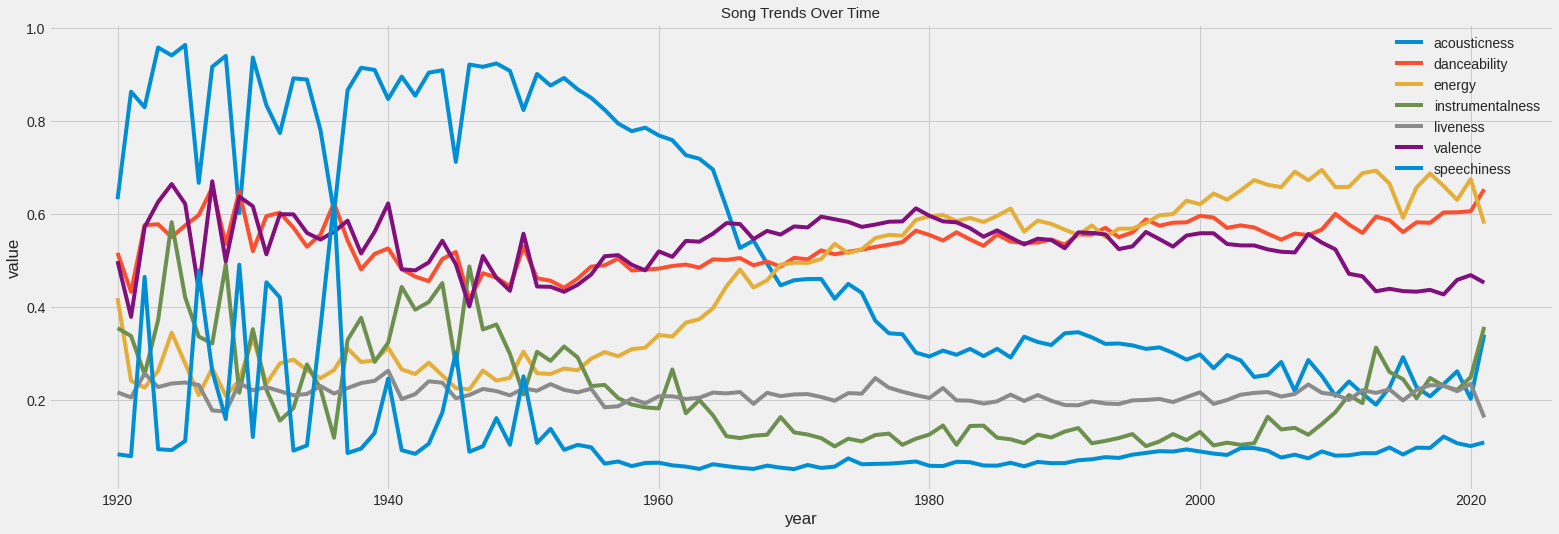

In [ ]:
# Create a line plot to see the trends
plt.title("Song Trends Over Time", fontdict={"fontsize": 15})

lines = ["acousticness","danceability","energy", 
         "instrumentalness", "liveness", "valence", "speechiness"]

for line in lines:
    ax = sns.lineplot(x='year', y=line, data=df_year)
    
    
plt.ylabel("value")
plt.legend(lines,loc = 'upper right');

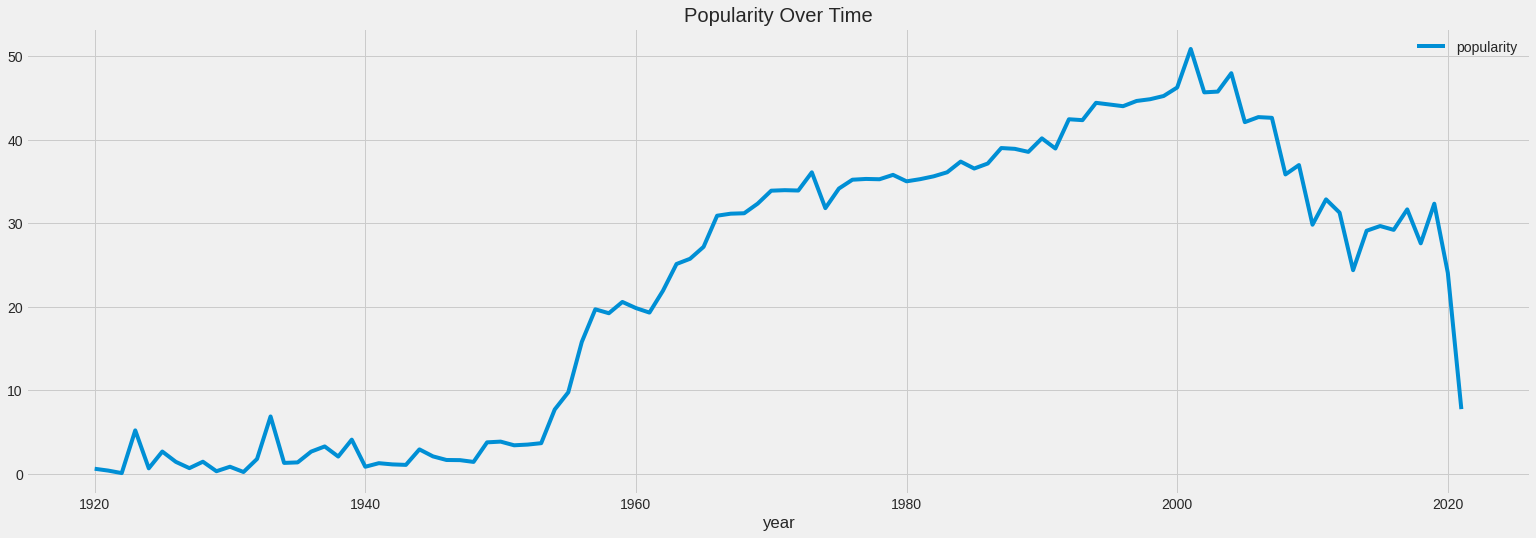

In [ ]:
# Popularity trend
df_year = df_original.groupby(by=["year"]).popularity.mean().reset_index()
pop = df_year.set_index('year')
pop = pd.DataFrame(pop)
pop.plot(title = 'Popularity Over Time');

In [ ]:
df_popularity = df_year[['year','popularity']]

# Convert the data type of year to Datetime
df_popularity['year'] = pd.to_datetime(df_popularity['year'], format = '%Y')

# Set the index as year
df_popularity.set_index('year',inplace = True)

df_popularity.head()

,popularity
year,
1920-01-01,0.610315
1921-01-01,0.391026
1922-01-01,0.090909
1923-01-01,5.205405
1924-01-01,0.661017


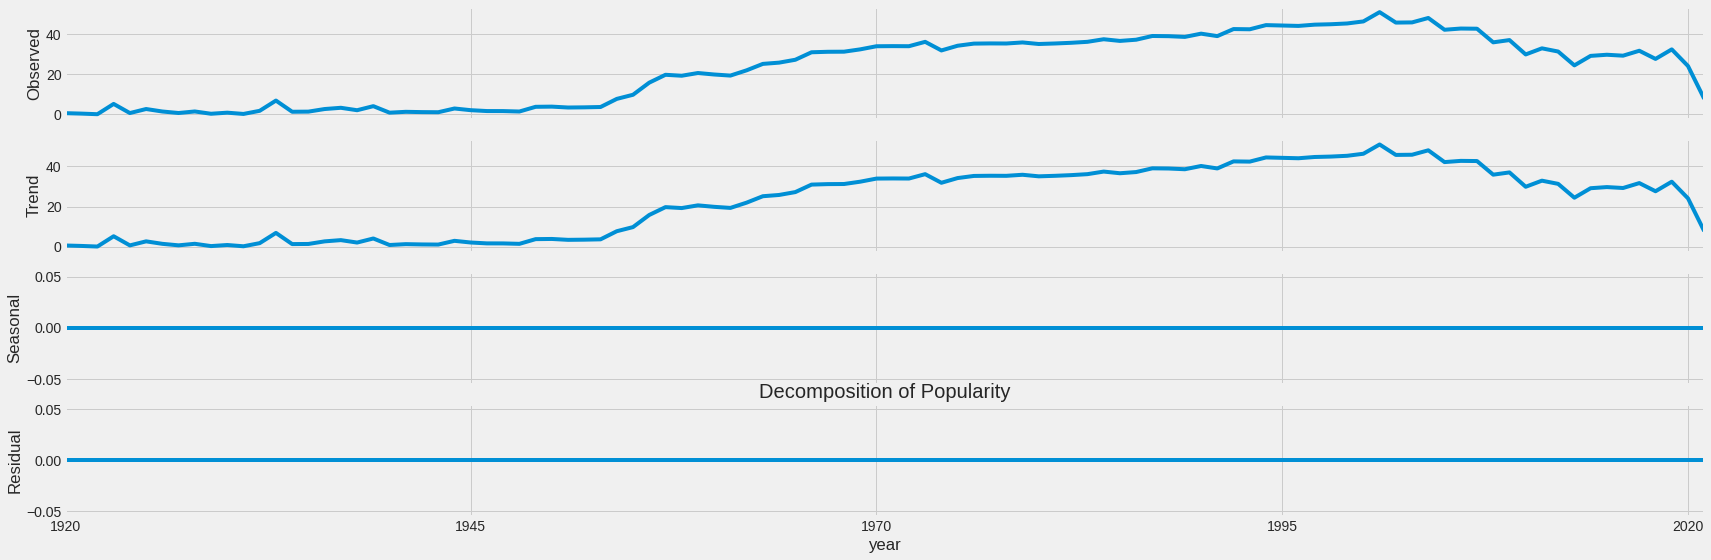

In [ ]:
# Decomposition
pop_decomposition = sm.tsa.seasonal_decompose(df_popularity, model = 'additive')
fig = pop_decomposition.plot()
plt.title('Decomposition of Popularity')
plt.show()

In [ ]:
# Define function for ADF test
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

# Apply adf test on the series
adf_test(df_popularity['popularity'])

Results of Dickey-Fuller Test:
Test Statistic                 -1.457798
p-value                         0.554275
#Lags Used                      8.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64


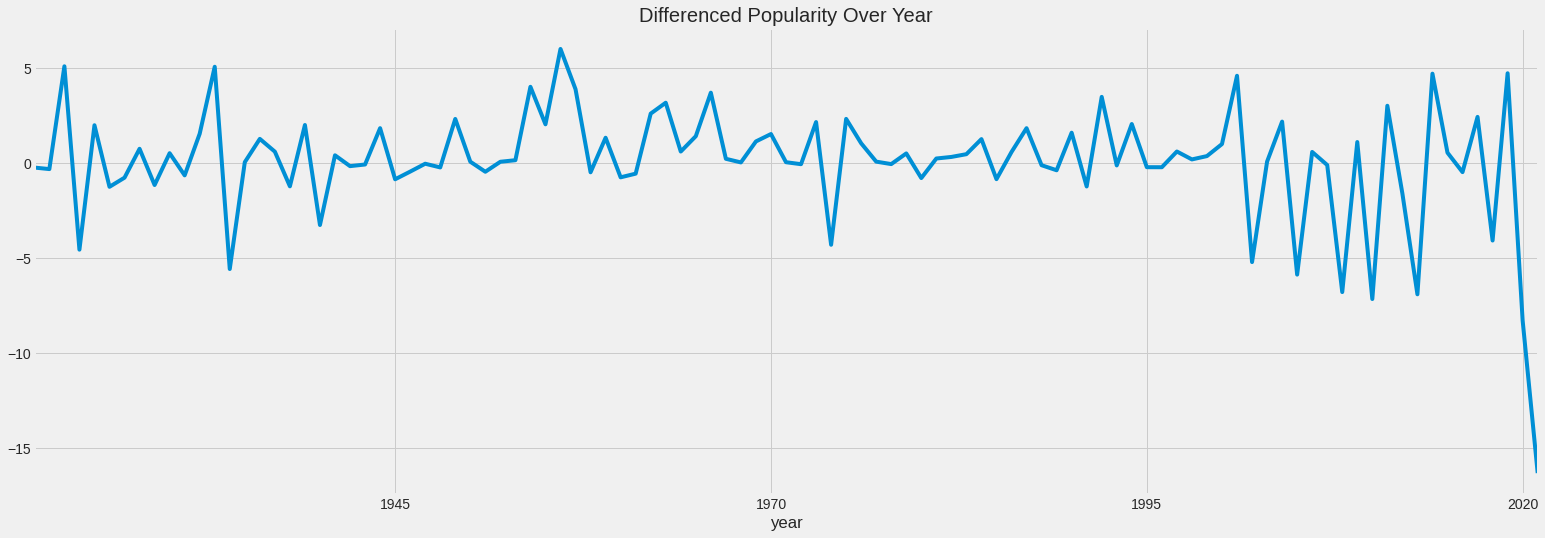

In [ ]:
# First order differencing
pop_diff = df_popularity['popularity'] - df_popularity['popularity'].shift(1)
pop_diff.dropna(axis='index', inplace=True)
pop_diff.plot(title = 'Differenced Popularity Over Year');

In [ ]:
adf_test(pop_diff)

Results of Dickey-Fuller Test:
Test Statistic                 -1.034915
p-value                         0.740318
#Lags Used                      7.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64


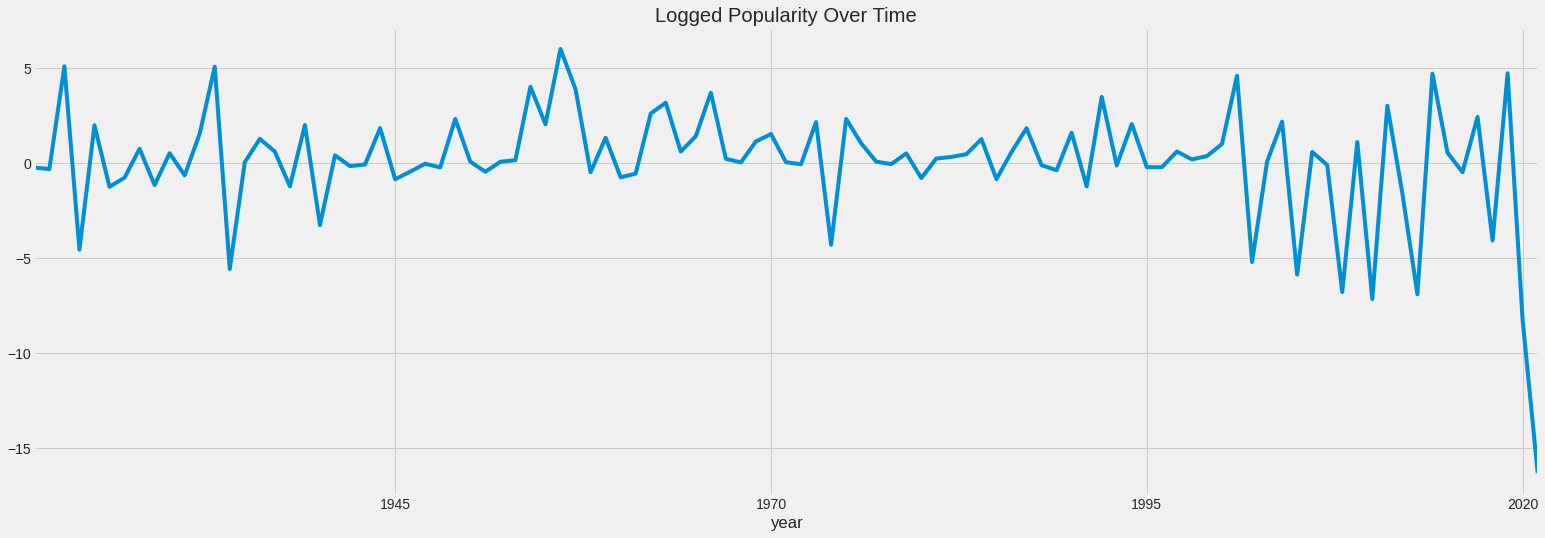

In [ ]:
# Transformation
pop_log = np.log(df_popularity['popularity'])
pop_log_diff = df_popularity['popularity'] - df_popularity['popularity'].shift(1)
pop_log_diff.dropna(axis='index', inplace=True)
pop_log_diff.plot(title = 'Logged Popularity Over Time')

In [ ]:
adf_test(pop_log_diff)

Results of Dickey-Fuller Test:
Test Statistic                 -1.034915
p-value                         0.740318
#Lags Used                      7.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64


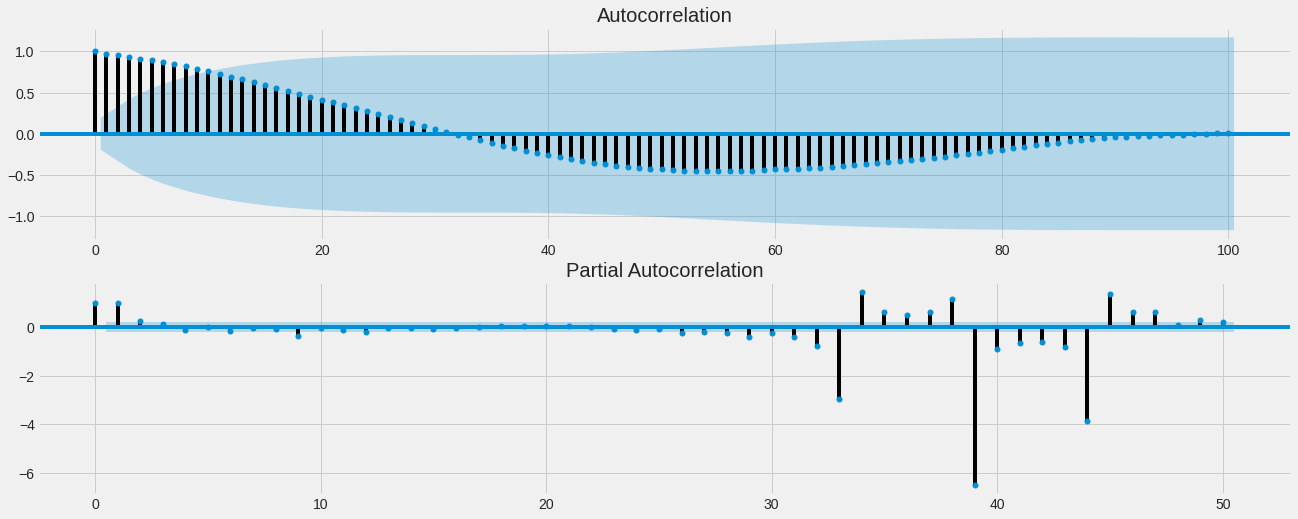

In [ ]:
# acf and pacf

fig, ax = plt.subplots(2,figsize=(20,8))
ax[0] = plot_acf(df_popularity['popularity'], ax=ax[0], lags=100)
ax[1] = plot_pacf(df_popularity['popularity'], ax=ax[1], lags=50)


# Data Visualization

In [ ]:
# Define function which generates distplot
def generate_distplot(df, target_column, compare_column, subset0_name, subset1_name):
  plt.figure()
  subset0 = df[compare_column].loc[df[target_column] == 0]
  subset1 = df[compare_column].loc[df[target_column] == 1]
  sns.set_style('whitegrid')
  ax = sns.distplot(subset0, hist=True, kde_kws=dict(linewidth=4), color = "lightsalmon" )
  ax = sns.distplot(subset1, hist=True, kde_kws=dict(linewidth=4), color = "lightseagreen")
  plt.legend([subset0_name, subset1_name],fontsize=20)

In [ ]:
df.describe()

,acousticness,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year,duration_mins
count,37765.00000,37765.00000,37765.000000,37765.000000,37765.000000,37765.000000,37765.000000,37765.000000,37765.000000,37765.000000,37765.000000,37765.000000,37765.000000,37765.000000,37765.000000
mean,0.24636,0.58159,0.657073,0.159672,0.197747,5.316007,0.217905,-8.104672,0.647901,34.453091,0.093136,122.870148,0.478982,2011.934092,4.072395
std,0.30725,0.17382,0.239198,0.366306,0.339942,3.572656,0.191730,4.574156,0.477631,28.486336,0.108669,28.160212,0.256032,6.132960,3.147555
min,0.00000,0.05510,0.000099,0.000000,0.000000,0.000000,0.009670,-45.353000,0.000000,0.000000,0.022300,34.631000,0.000000,2000.000000,0.283333
25%,0.00660,0.46800,0.503000,0.000000,0.000000,2.000000,0.096600,-9.603000,0.000000,1.000000,0.036500,100.119000,0.271000,2007.000000,3.076917
50%,0.08790,0.59100,0.693000,0.000000,0.000118,6.000000,0.134000,-6.996000,1.000000,46.000000,0.051300,124.998000,0.471000,2013.000000,3.718667
75%,0.41800,0.71100,0.856000,0.000000,0.246000,8.000000,0.289000,-5.207000,1.000000,59.000000,0.095000,139.020000,0.683000,2017.000000,4.514217
max,0.99600,0.98700,1.000000,1.000000,1.000000,11.000000,1.000000,3.367000,1.000000,100.000000,0.962000,221.954000,1.000000,2021.000000,88.971700


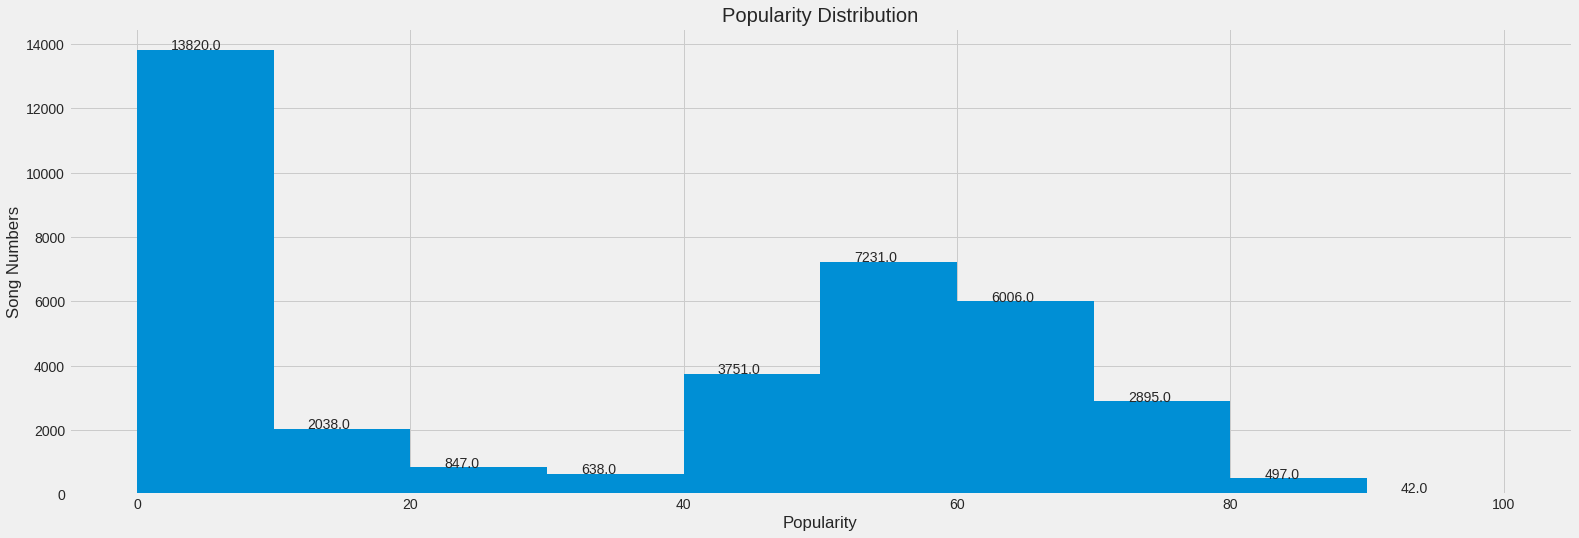

In [ ]:
# Visualize histogram - popularity
ax = plt.hist(df['popularity'], bins=10)
for i in range(10):
    plt.text(ax[1][i] + 2.5,ax[0][i],str(ax[0][i]))
plt.xlabel('Popularity')
plt.ylabel('Song Numbers')
plt.title('Popularity Distribution');

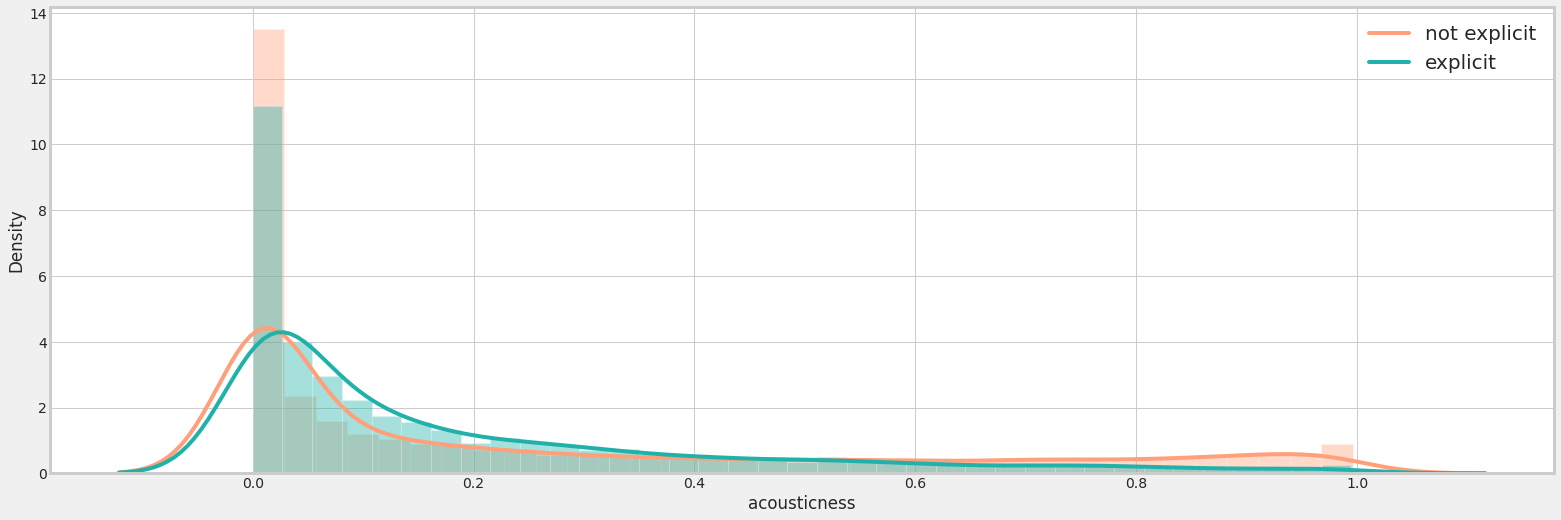

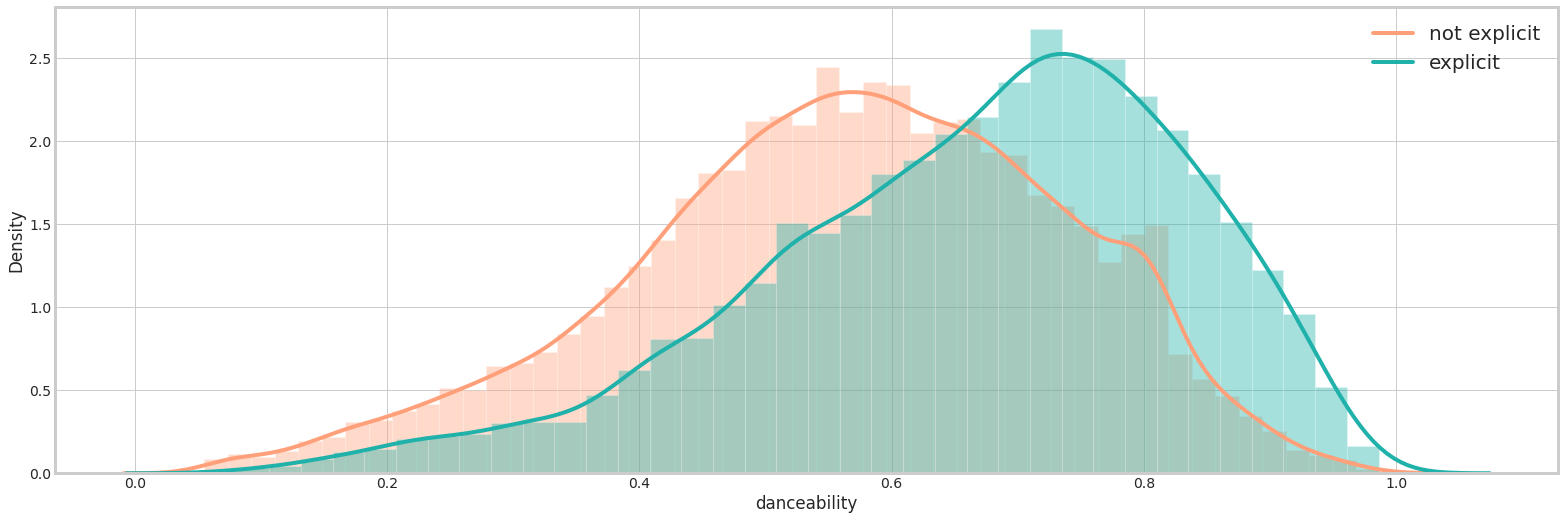

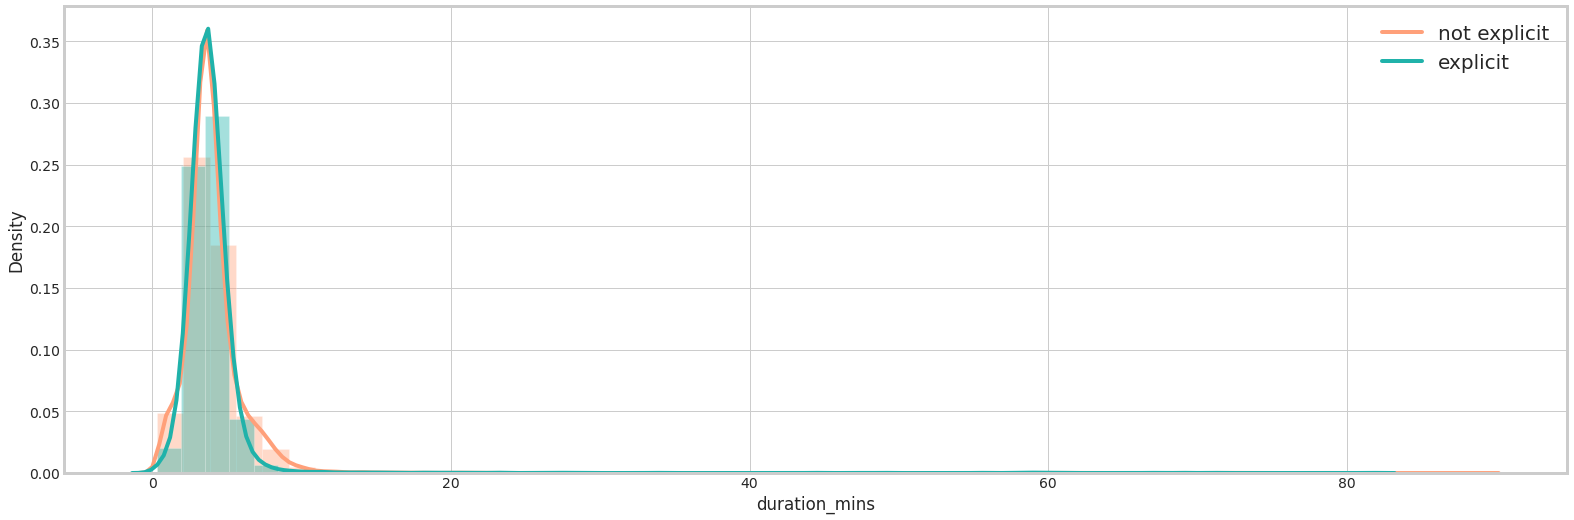

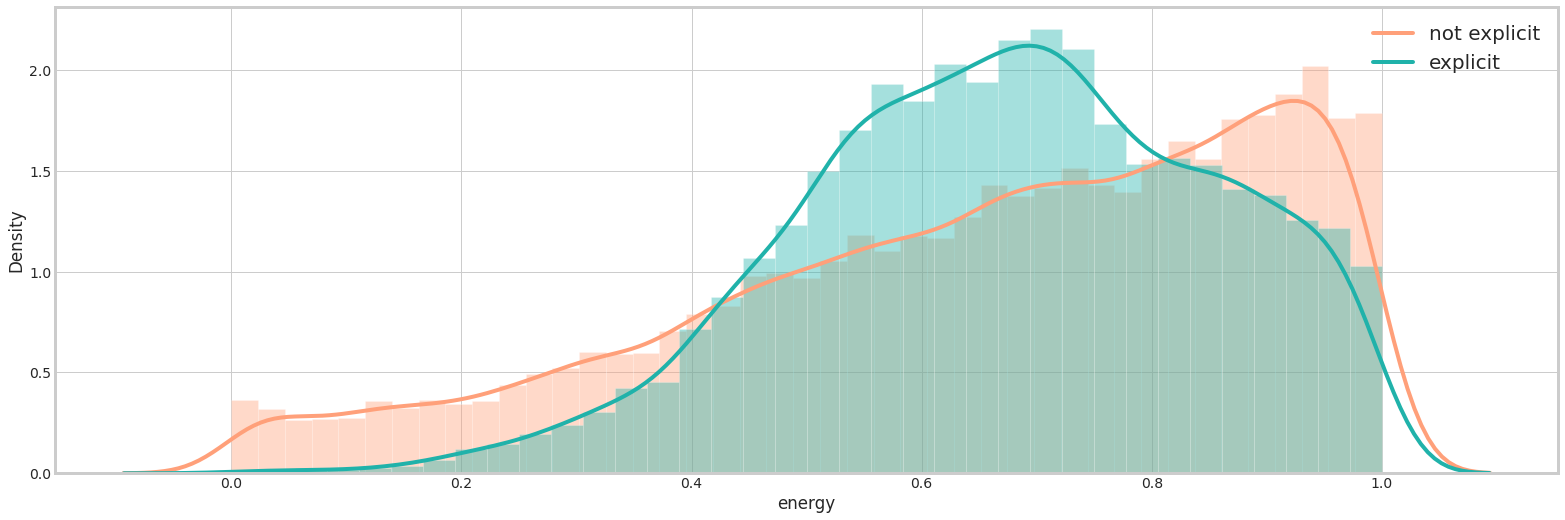

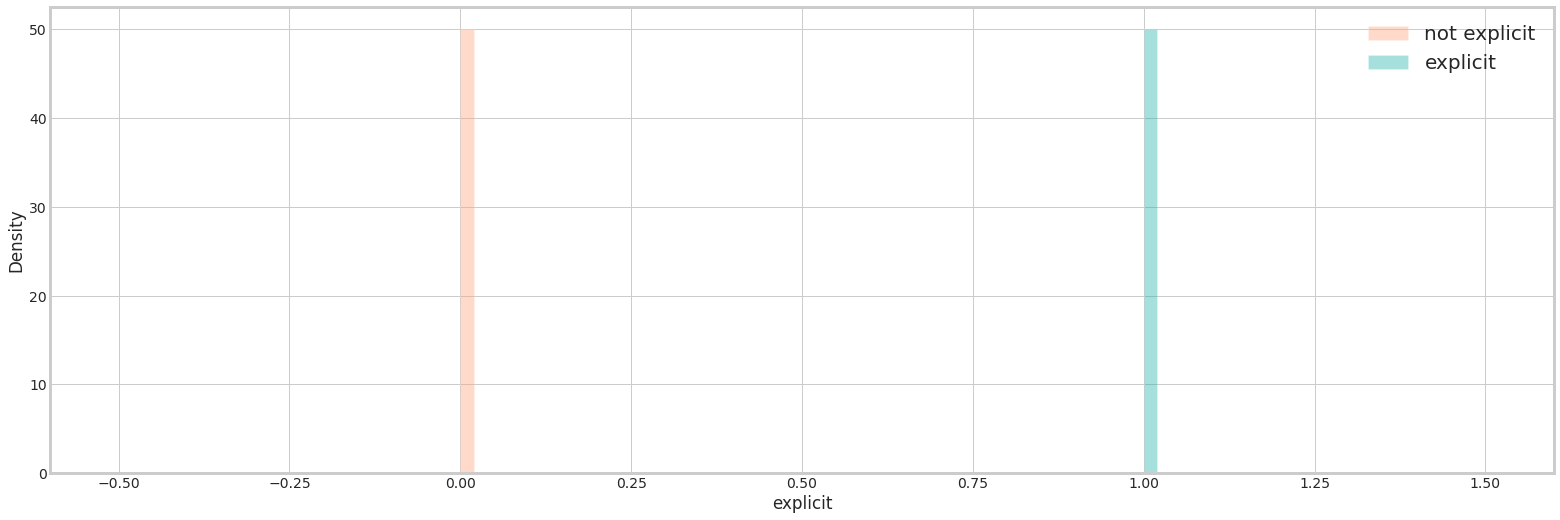

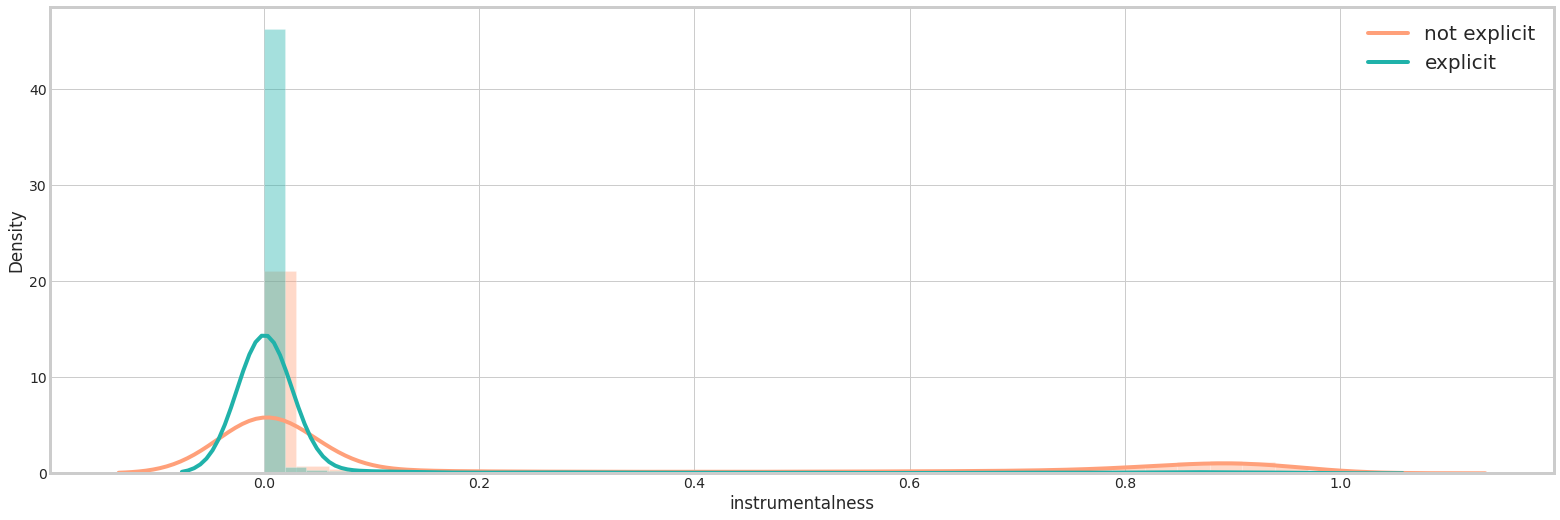

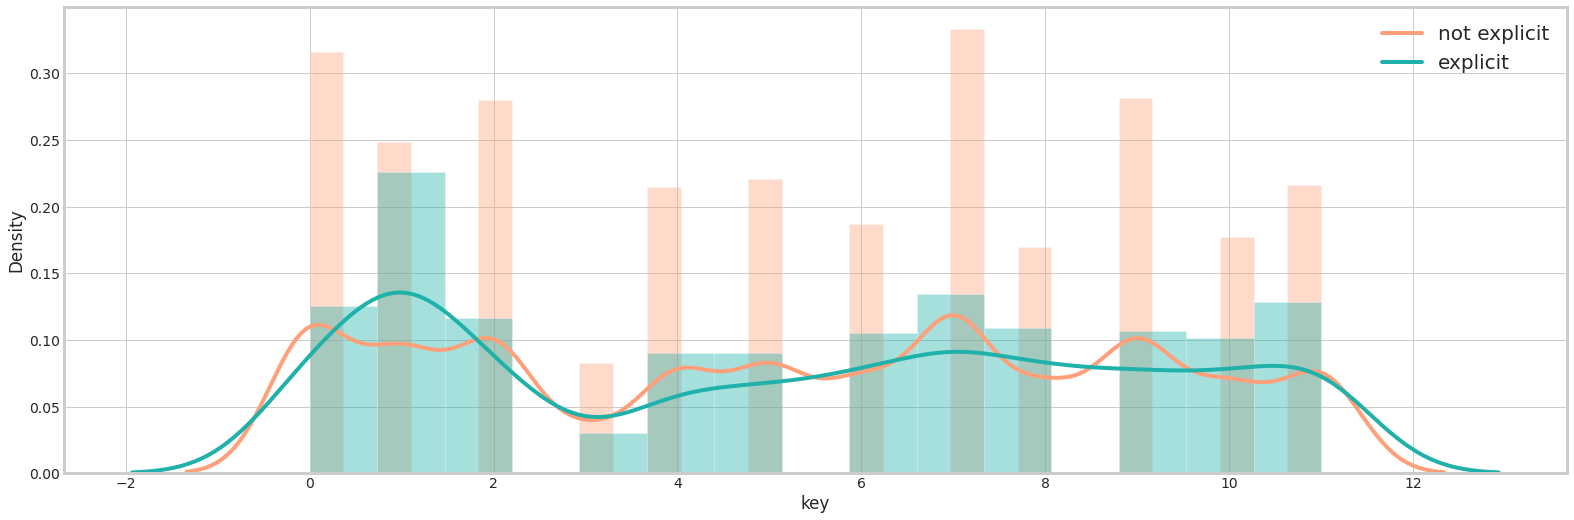

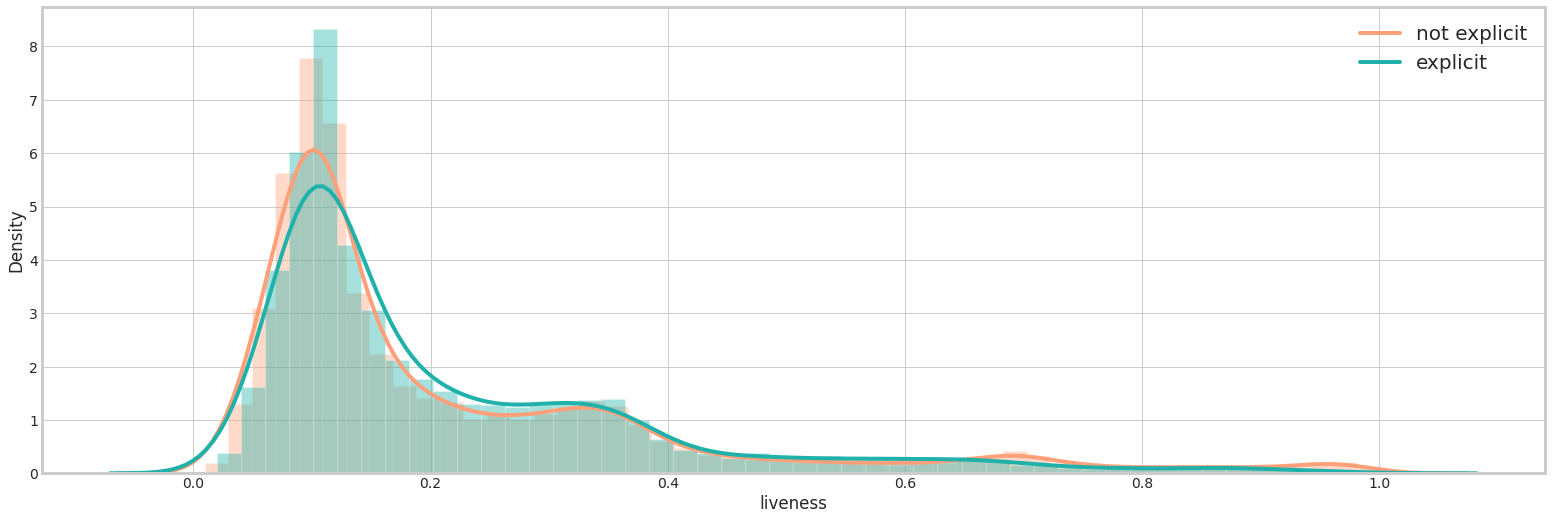

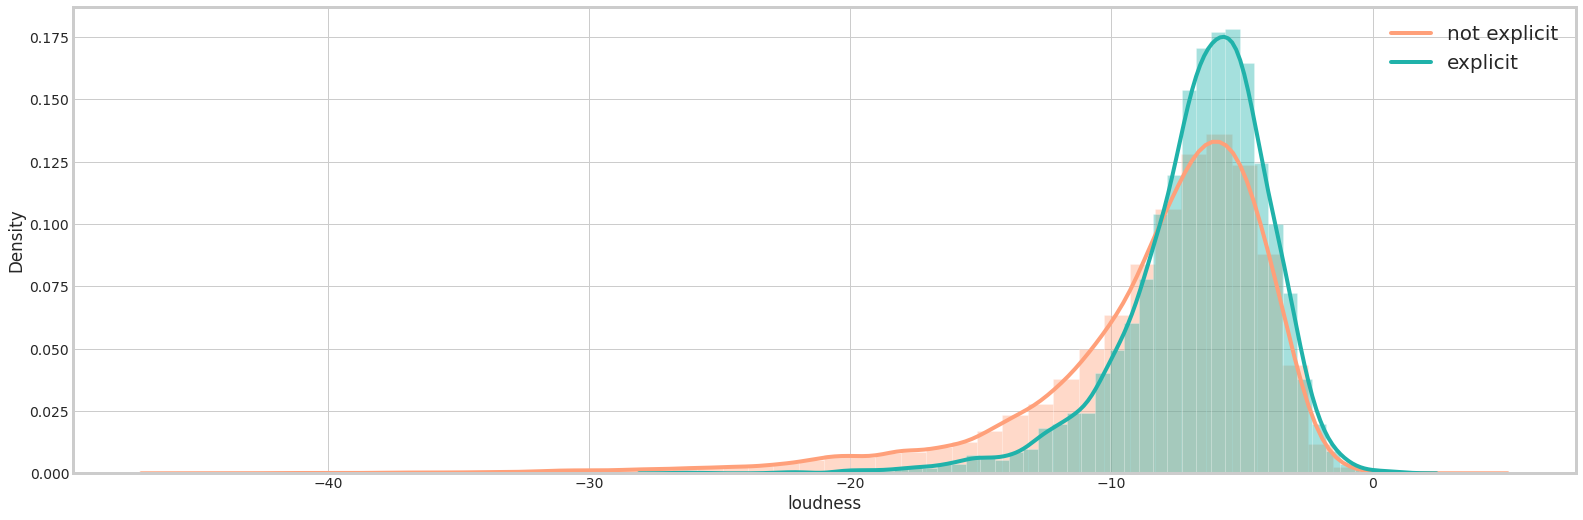

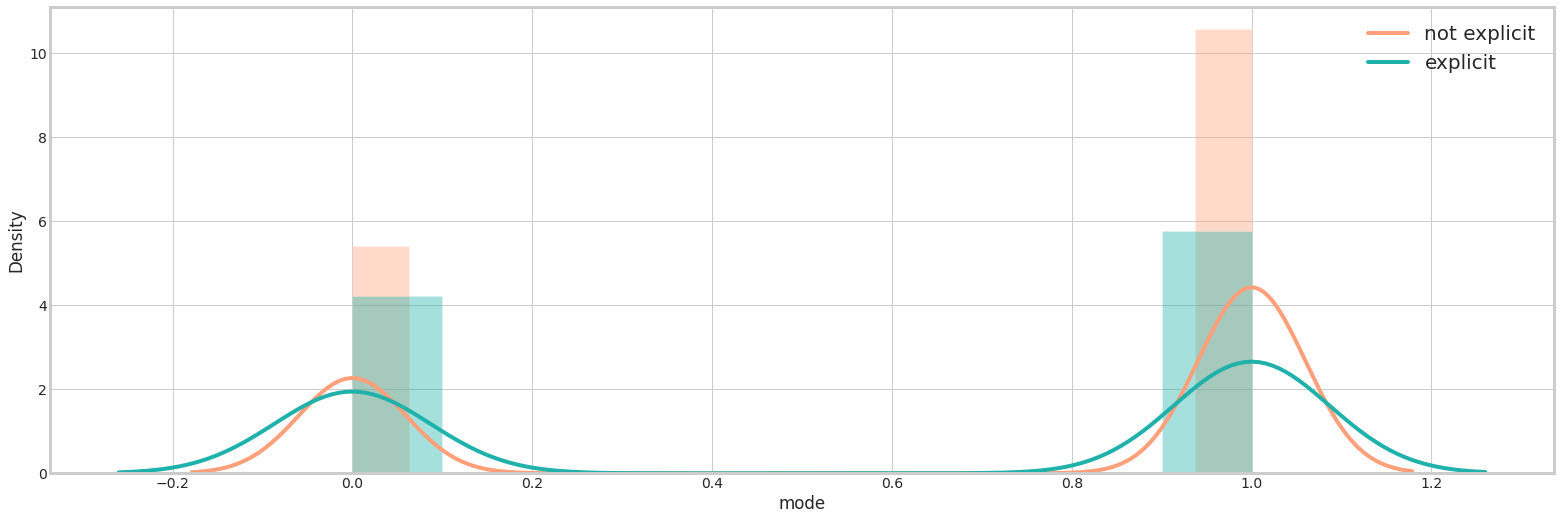

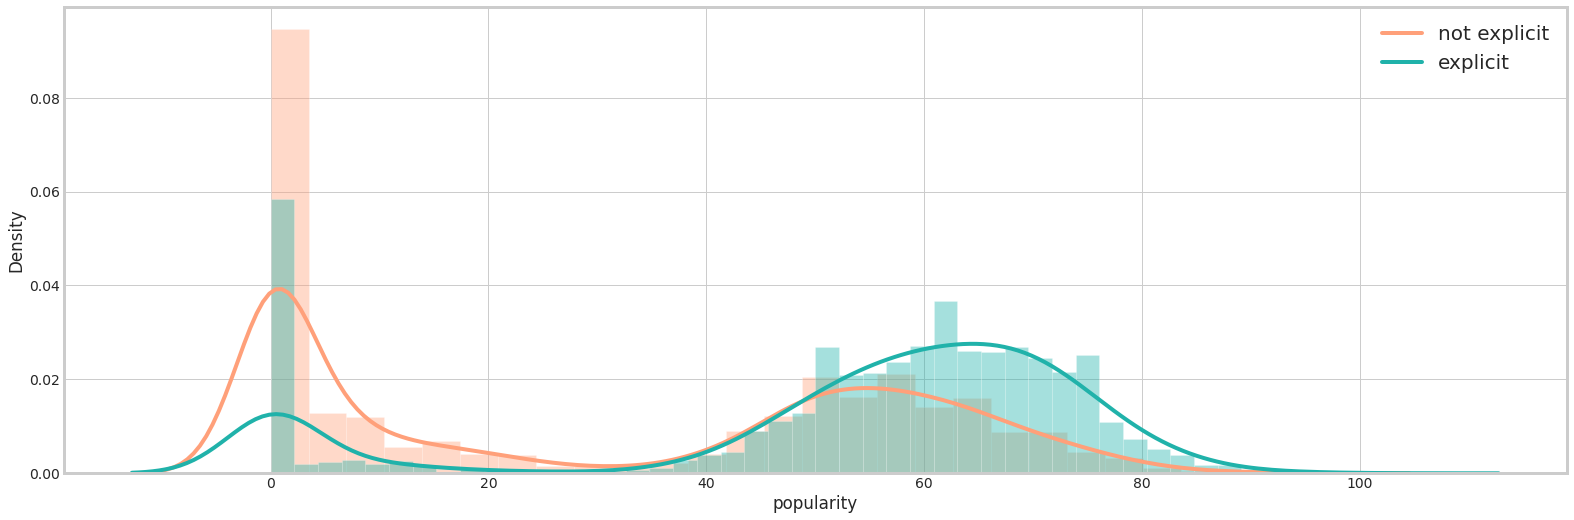

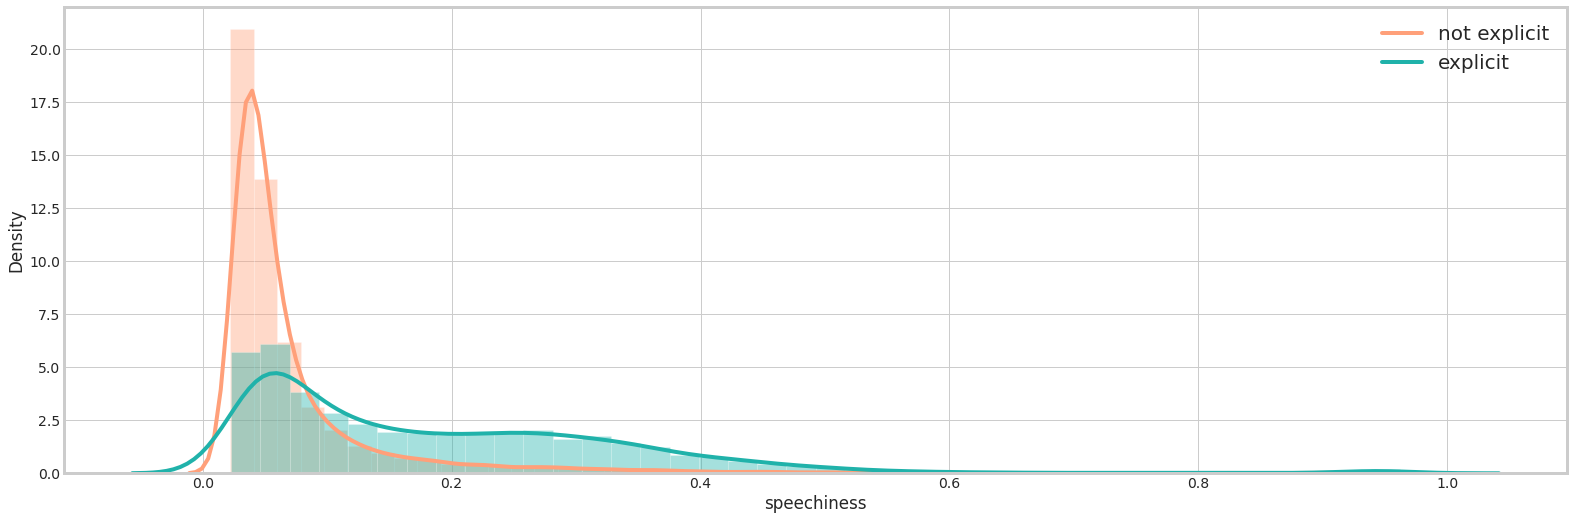

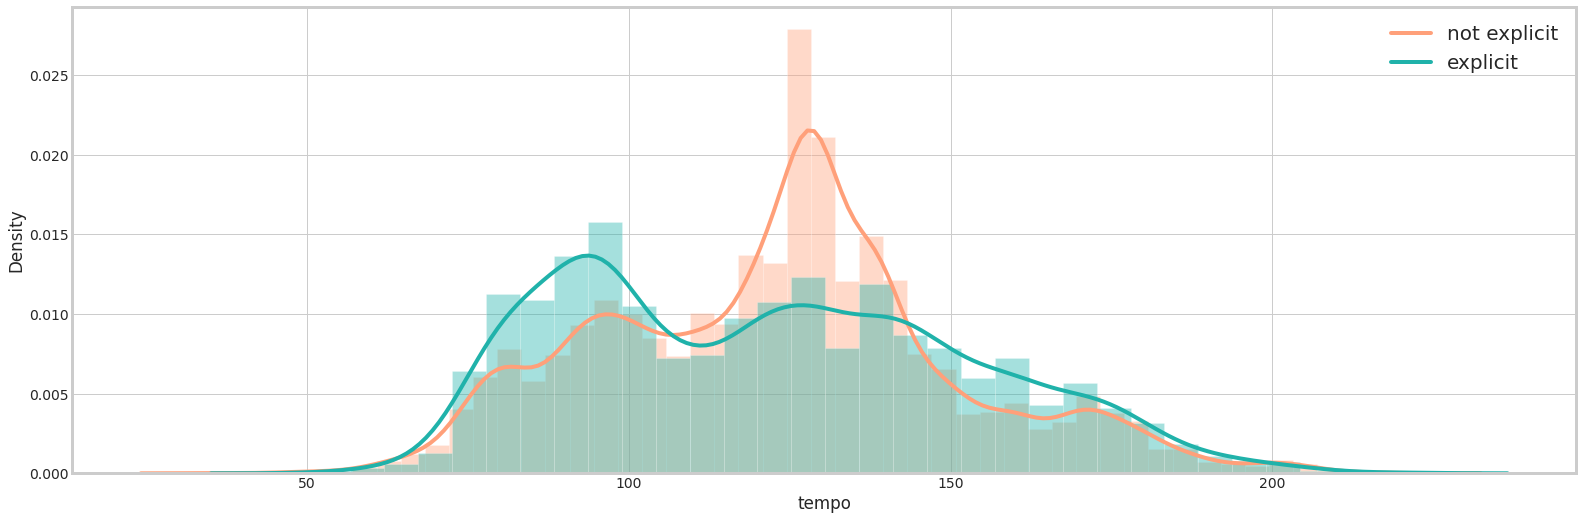

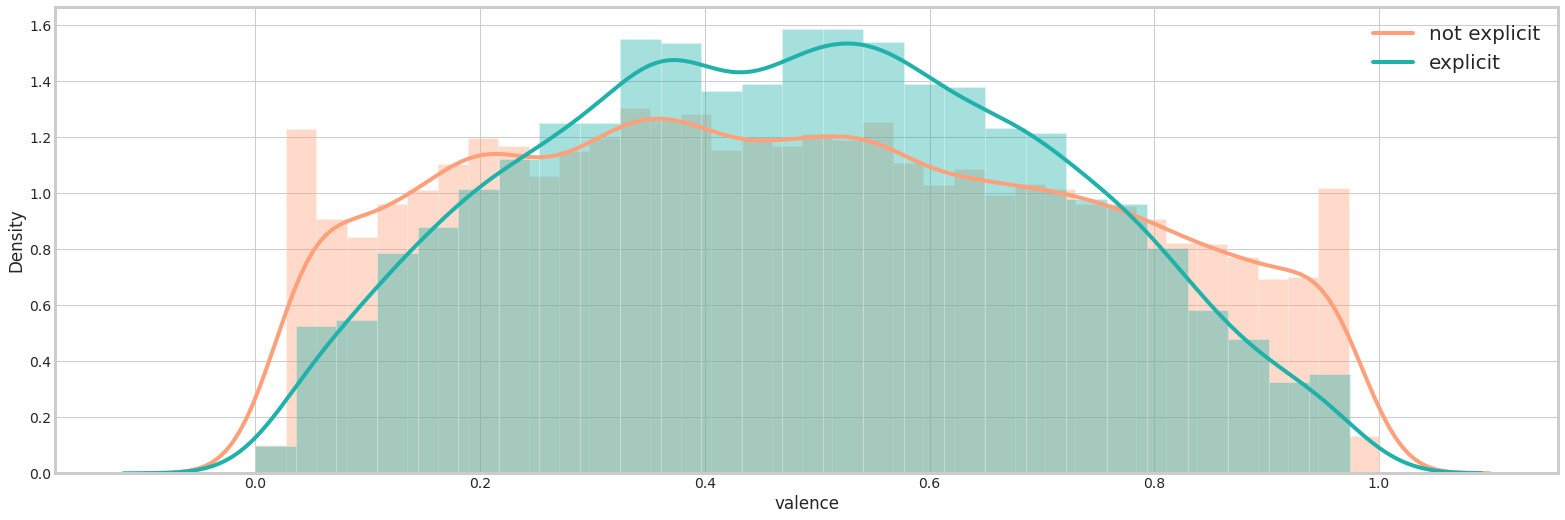

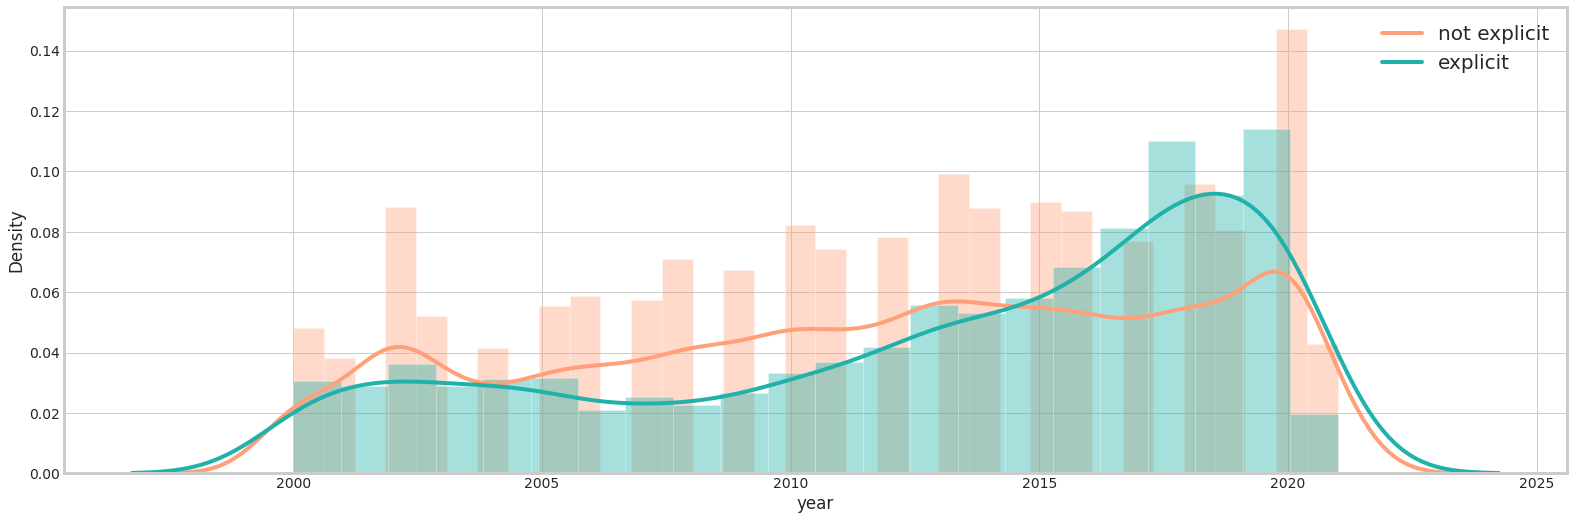

In [ ]:
# Visualize distplot - explicit
obj_list = list(df.select_dtypes(include = ["object"]).columns)
num_column = df.columns.difference(obj_list)
for i in num_column:
  generate_distplot(df, "explicit", i, "not explicit", "explicit")

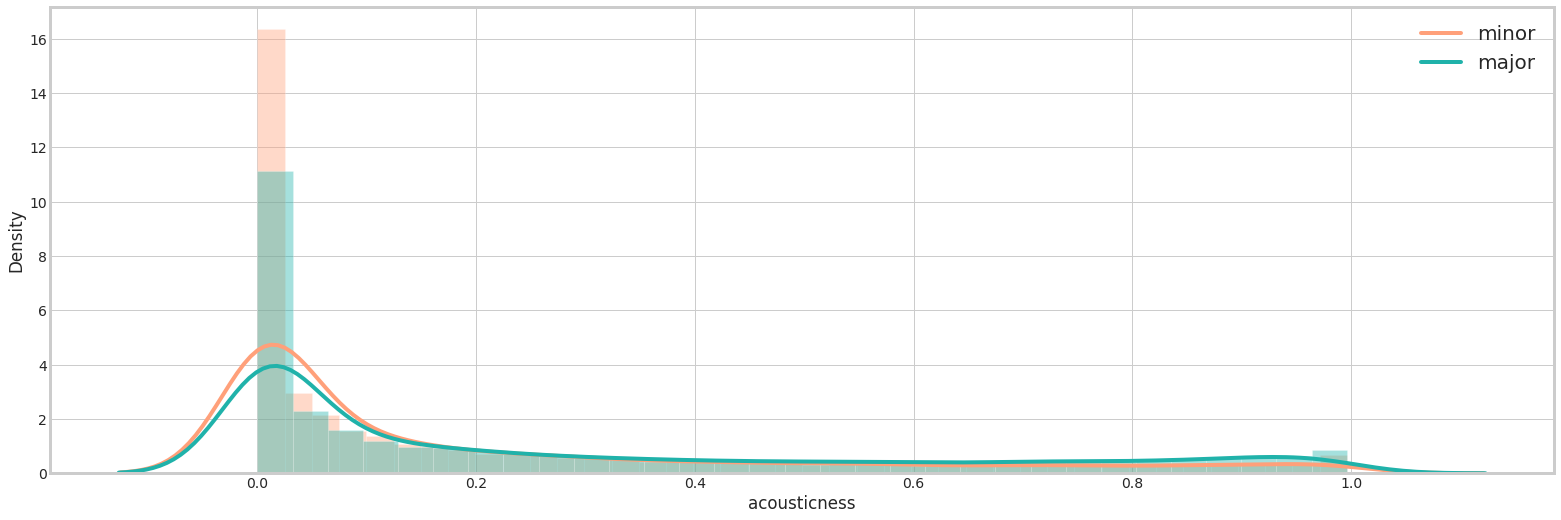

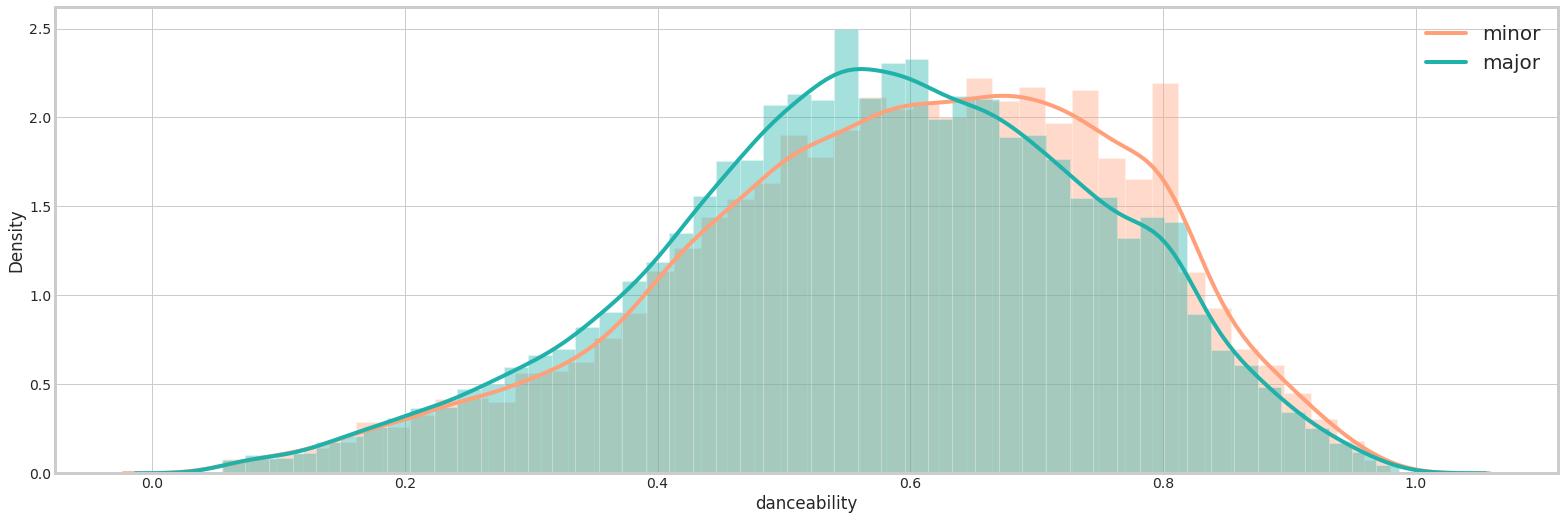

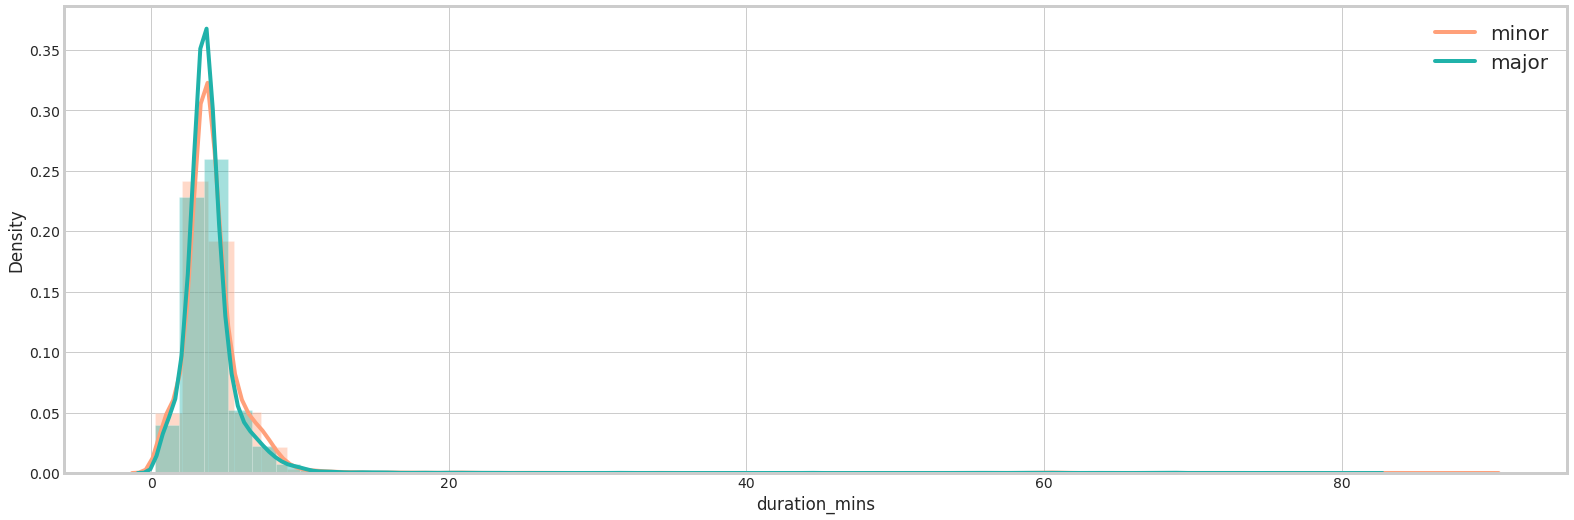

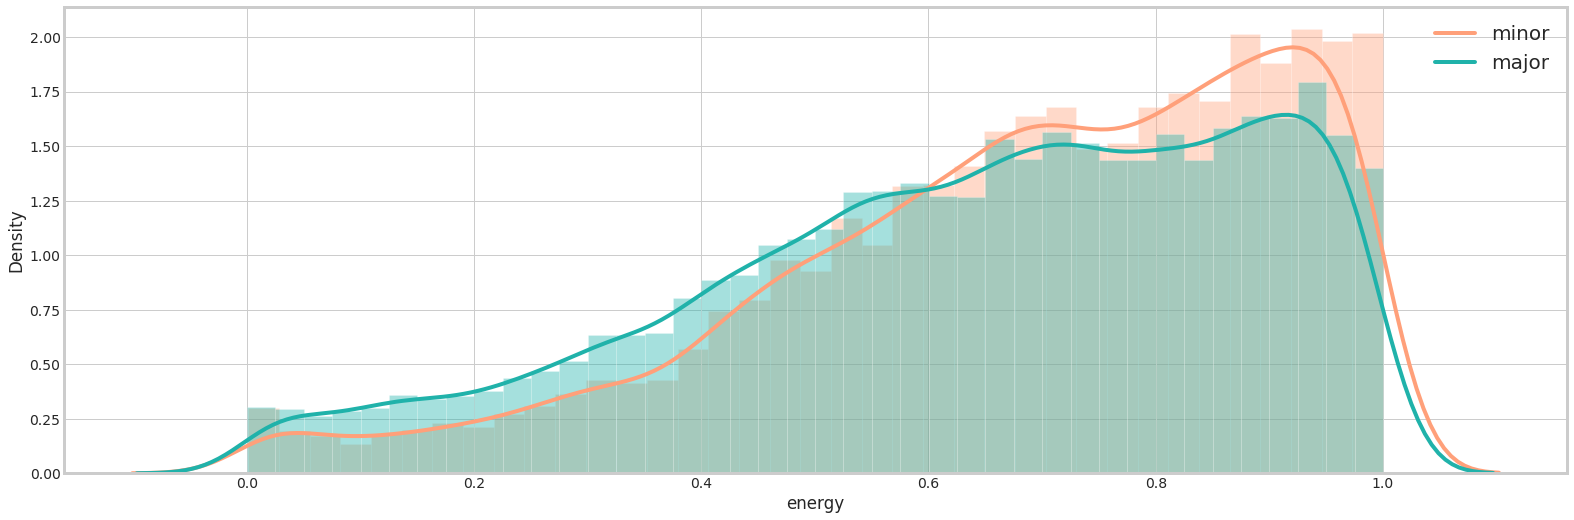

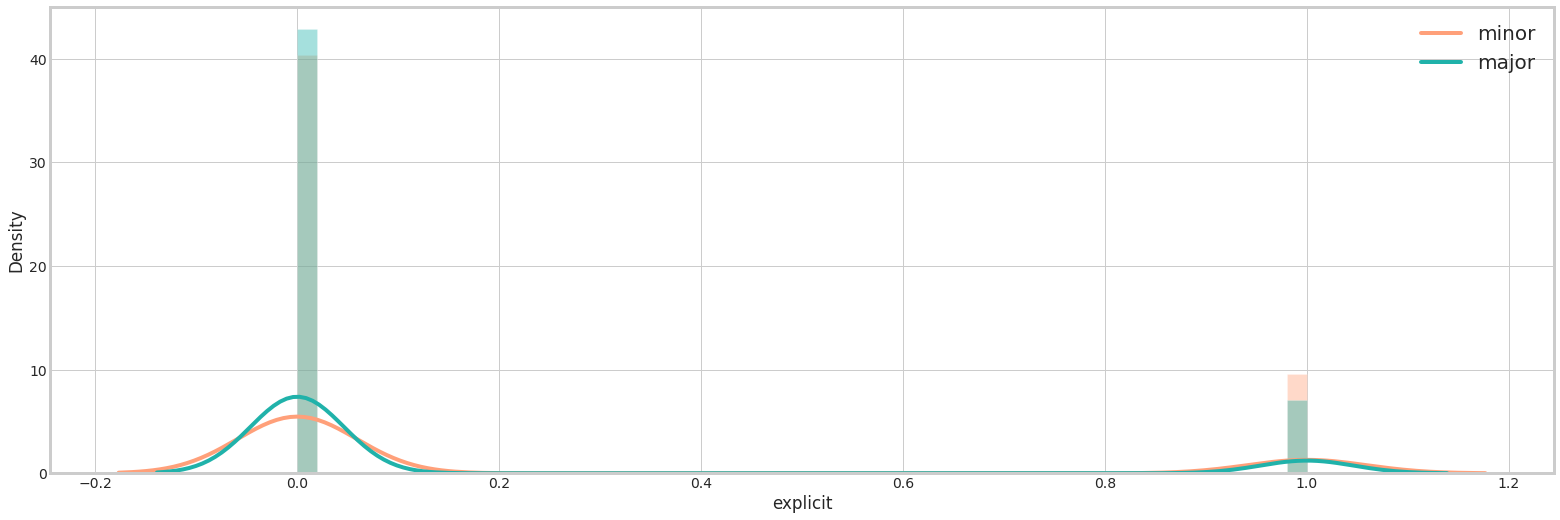

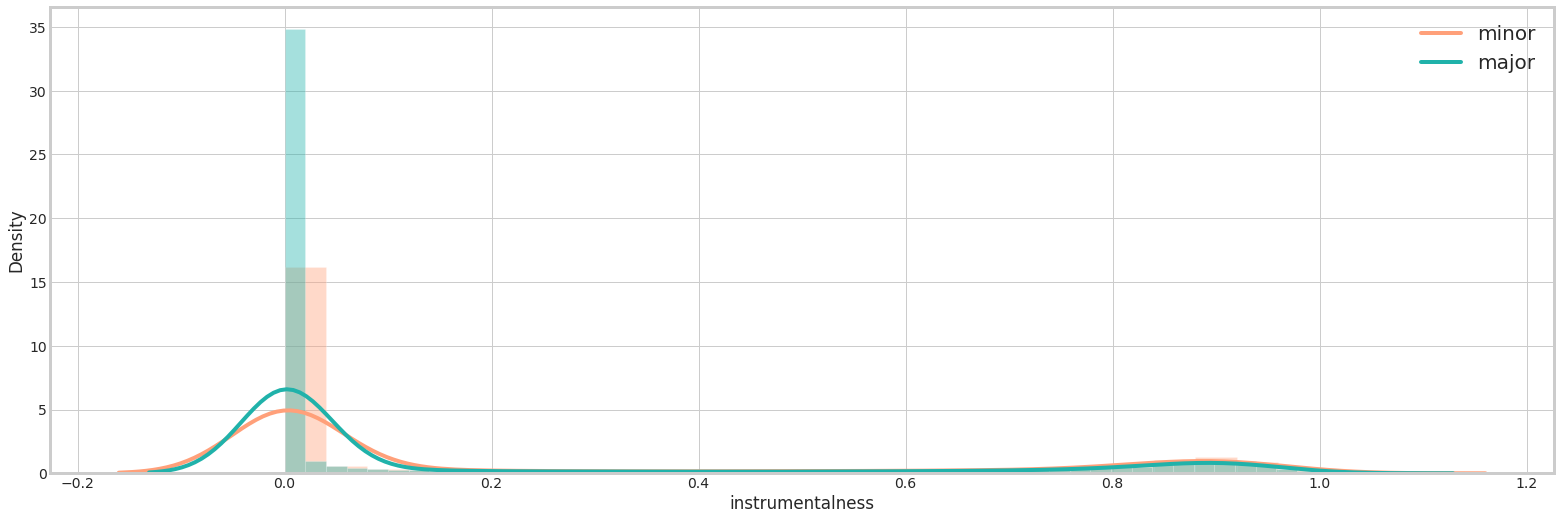

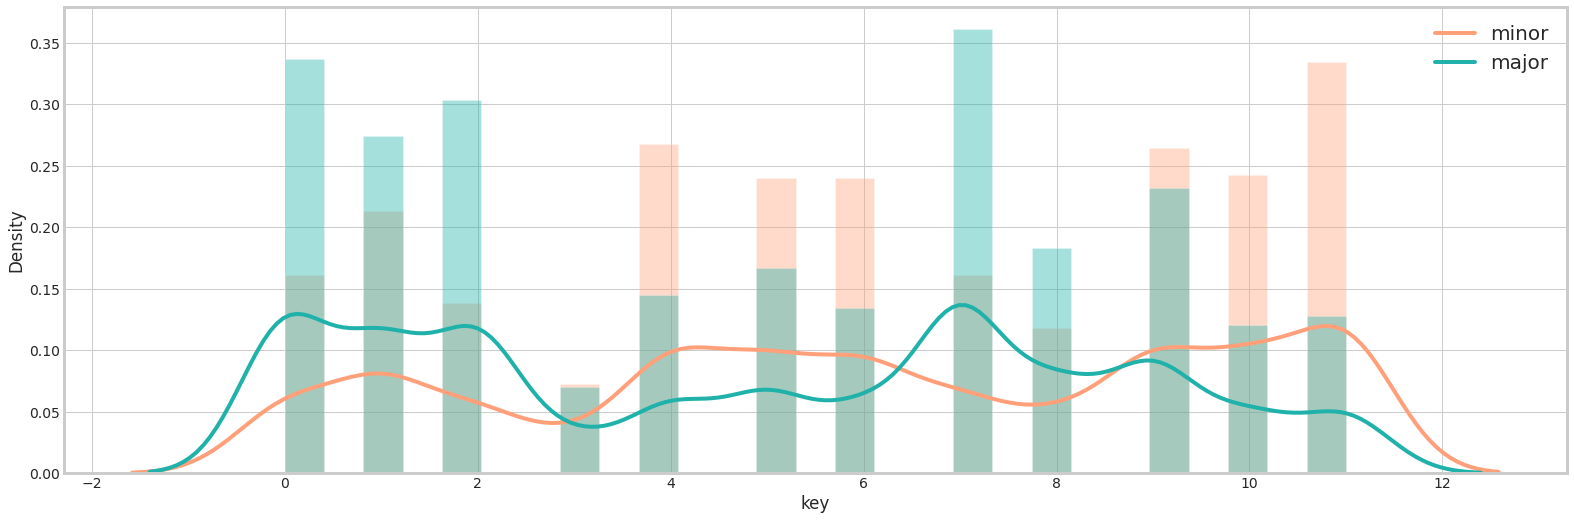

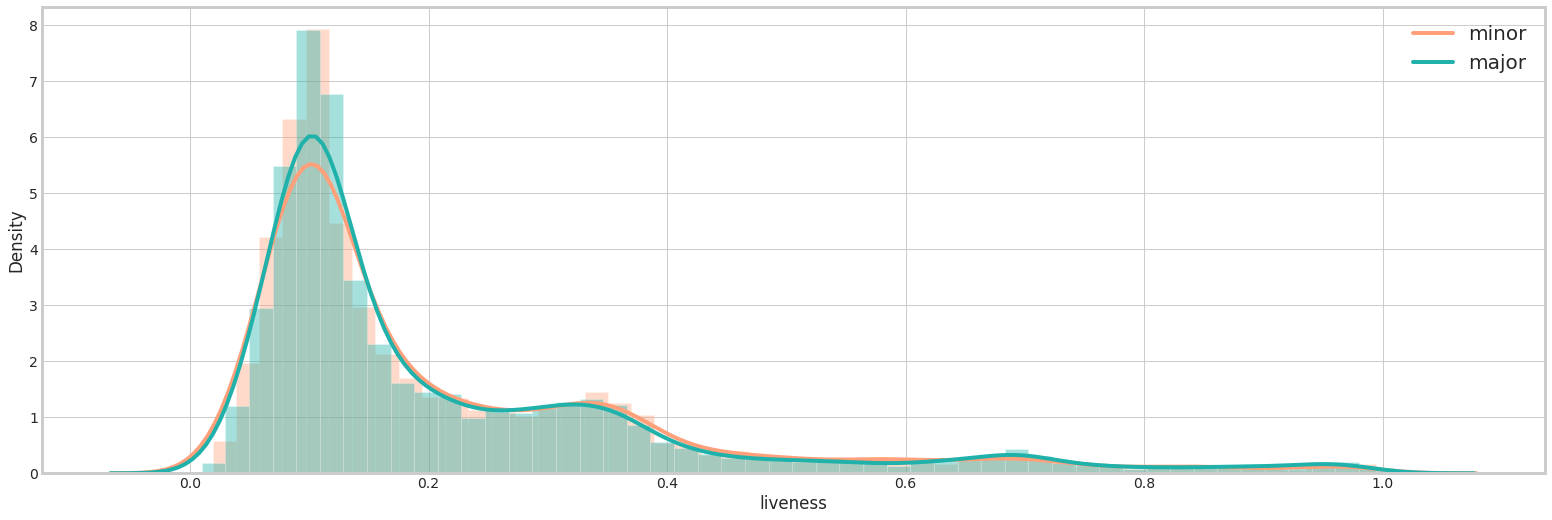

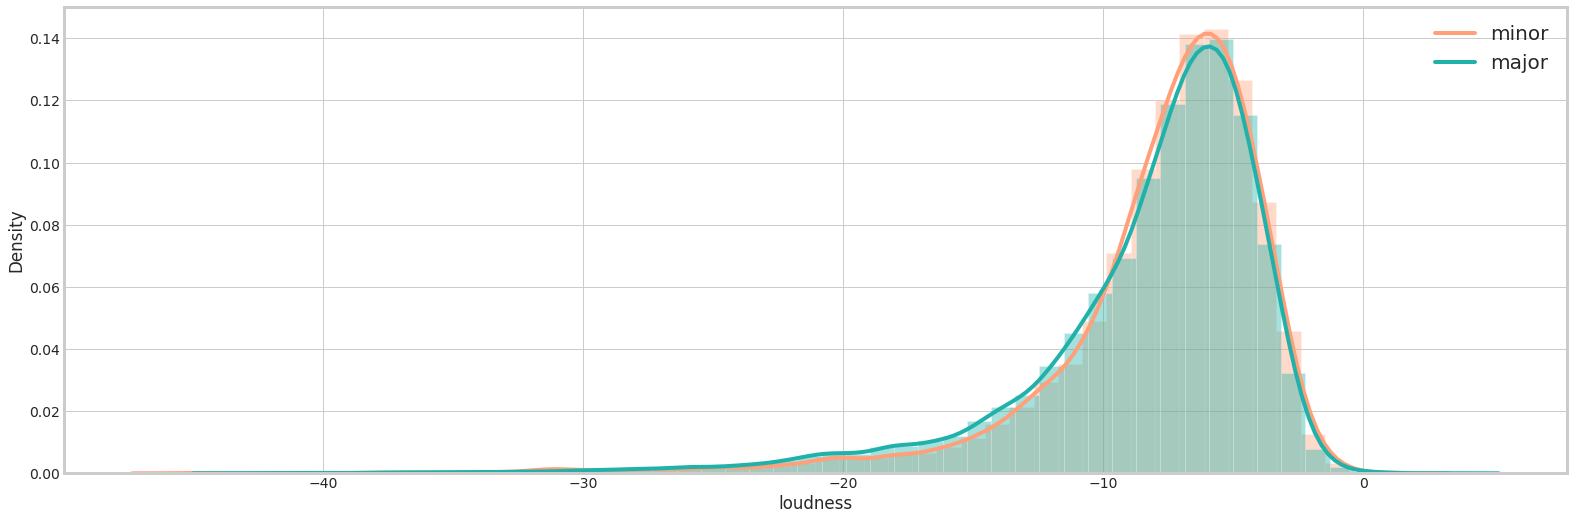

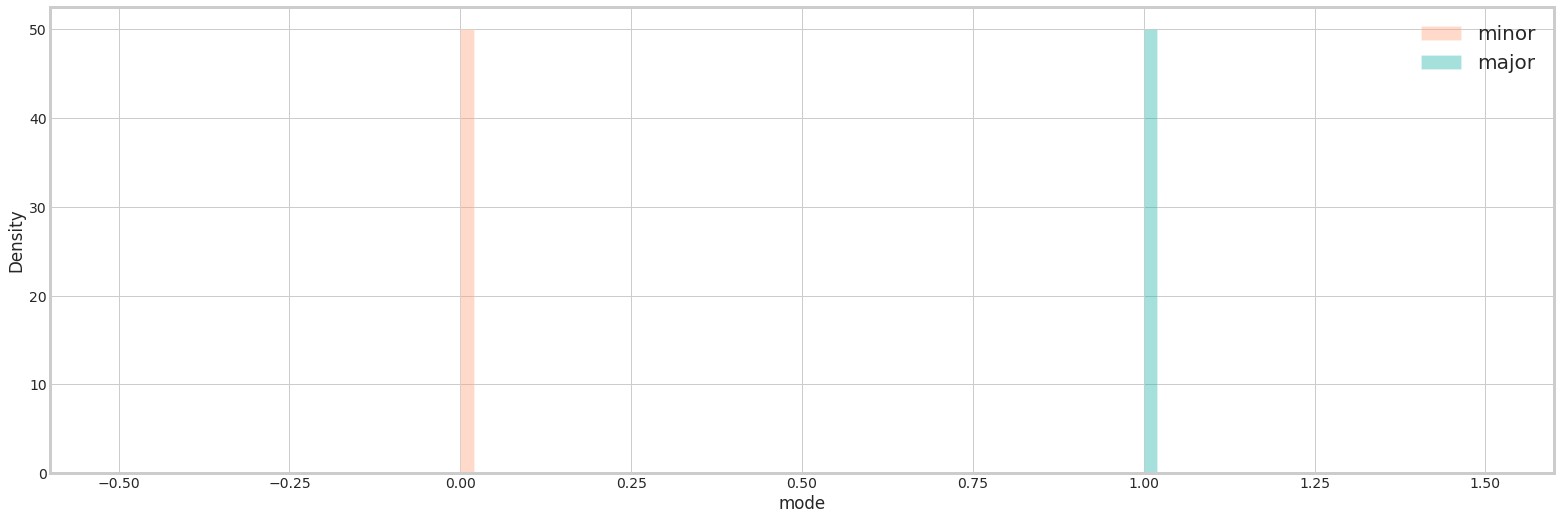

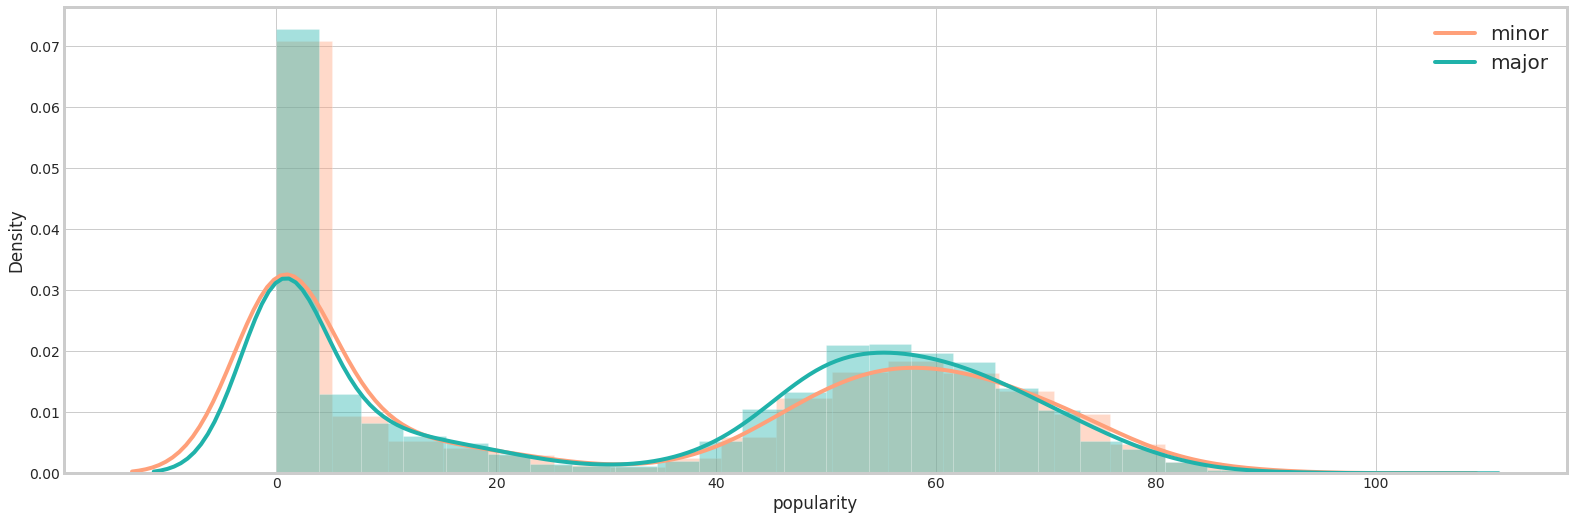

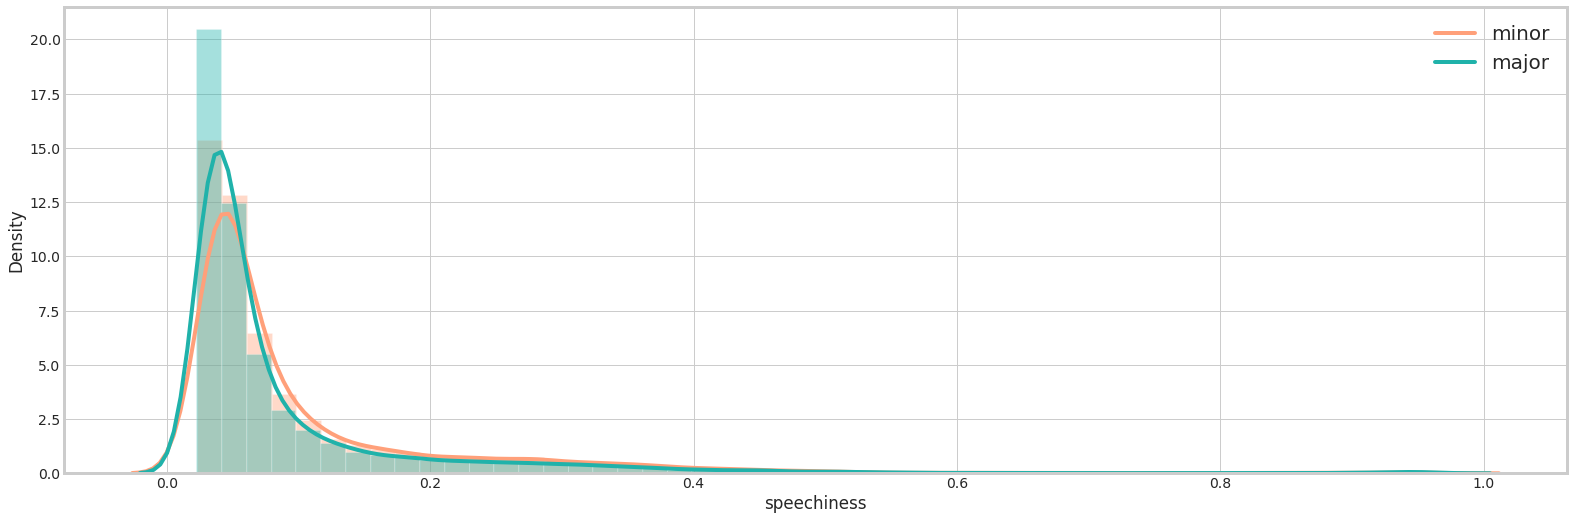

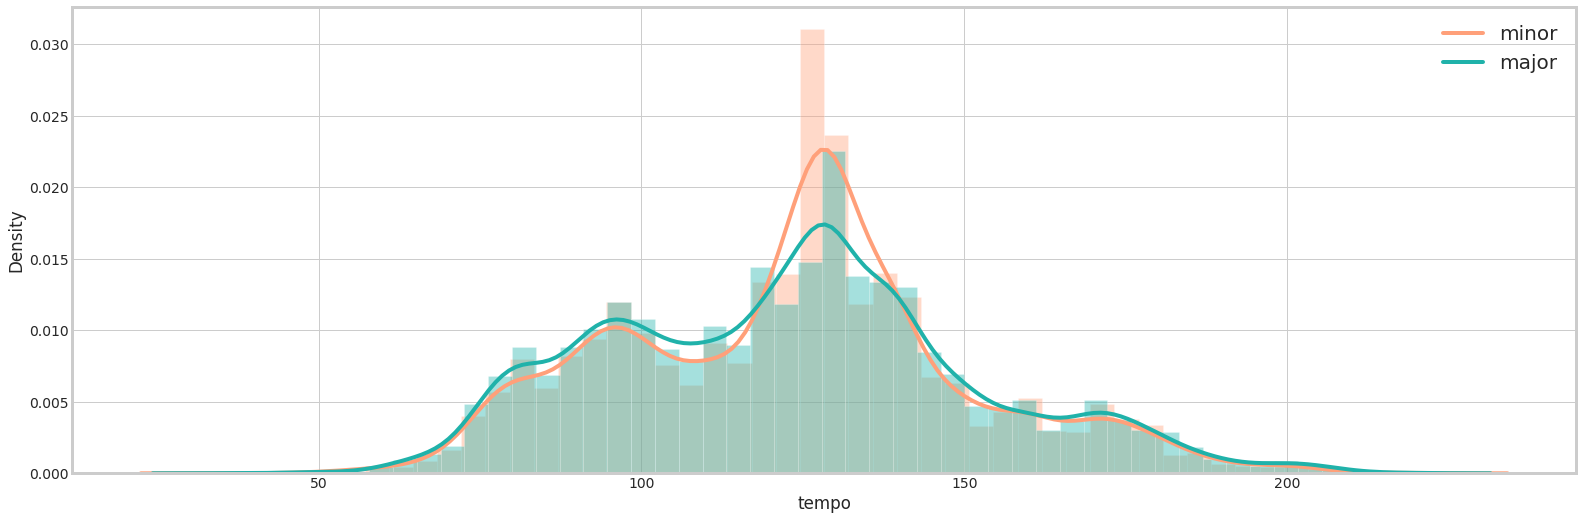

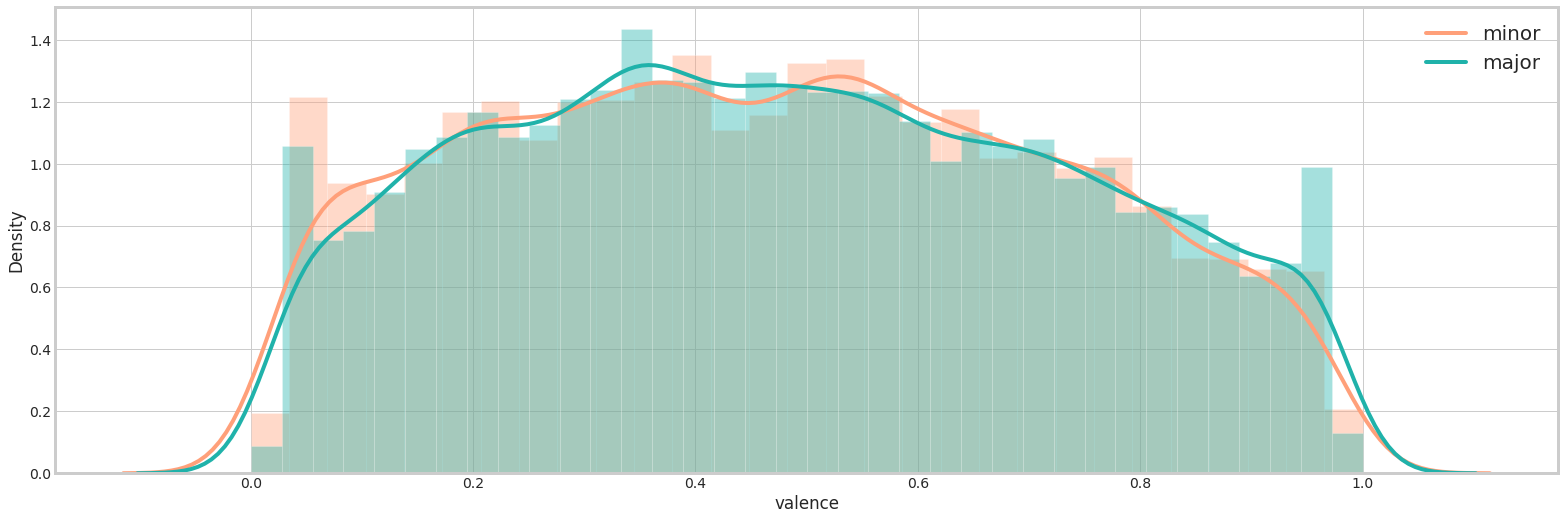

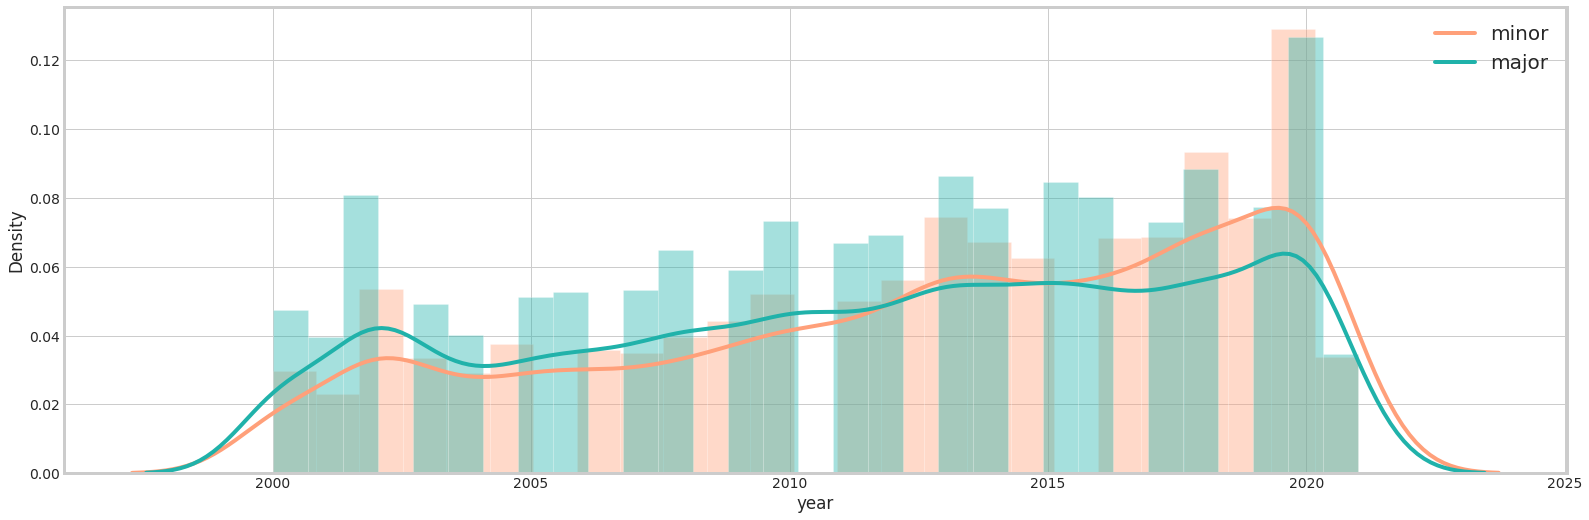

In [ ]:
# Visualize distplot - mode
for i in num_column:
  generate_distplot(df, "mode", i, "minor", "major")

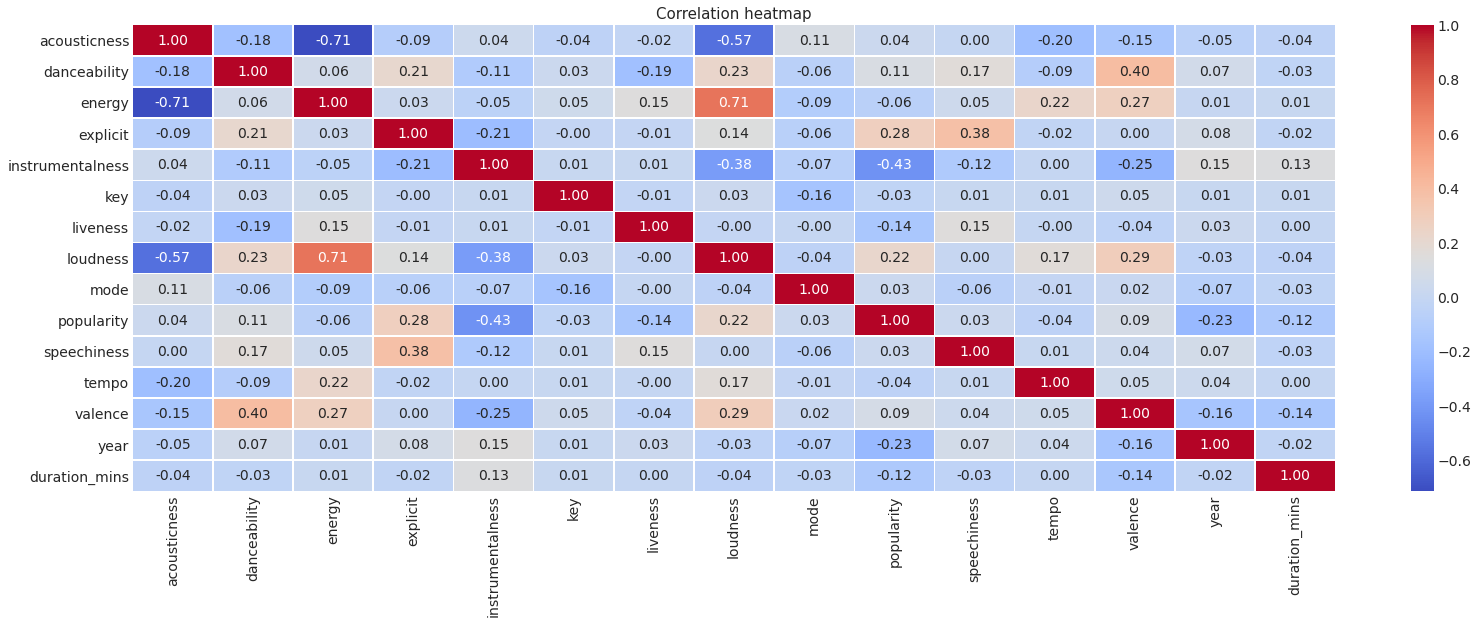

In [ ]:
# Check the correlation between features
corr = df.corr() 
f,ax = plt.subplots()
sns.heatmap(corr, annot = True, fmt= '.2f', 
            xticklabels= True, yticklabels= True
            ,cmap="coolwarm", linewidths=.5, ax=ax)
plt.title('Correlation heatmap', size=15);

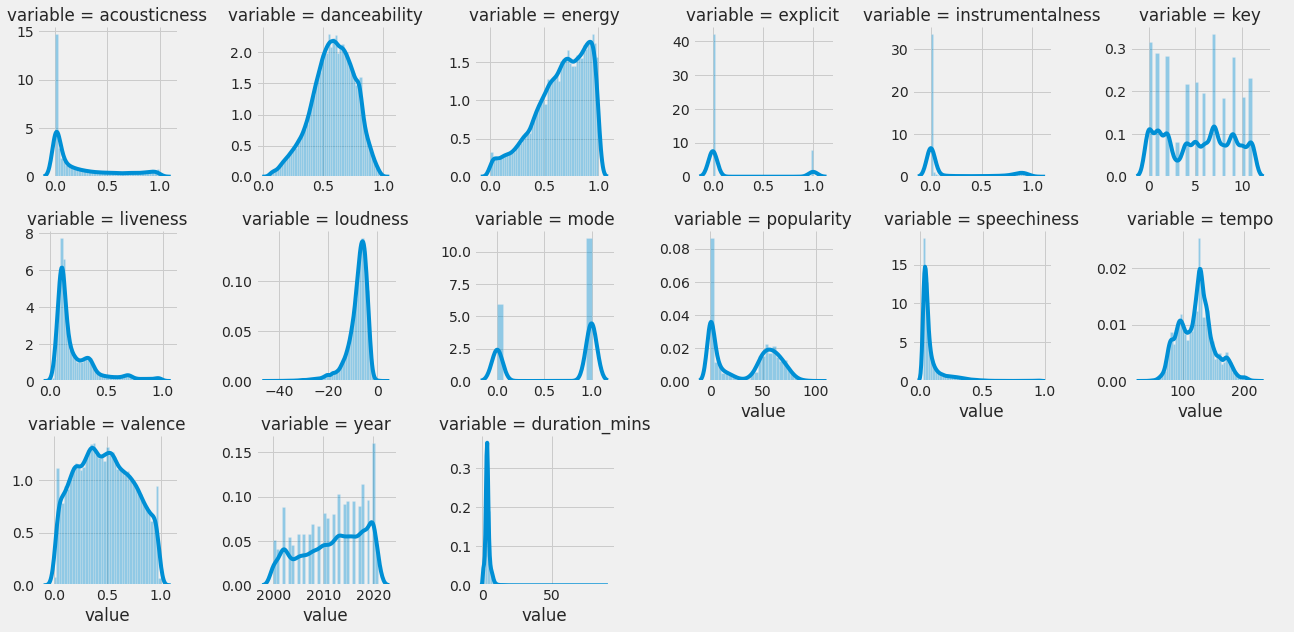

In [ ]:
# Data visualization of every feature
plt.style.use('fivethirtyeight')
cols = [ f for f in df.columns if df.dtypes[ f ] != "object"]
 
f = pd.melt( df, value_vars=cols)
g = sns.FacetGrid( f, col="variable", col_wrap=6, sharex=False, sharey=False )
g = g.map( sns.distplot, "value", kde=True).add_legend()

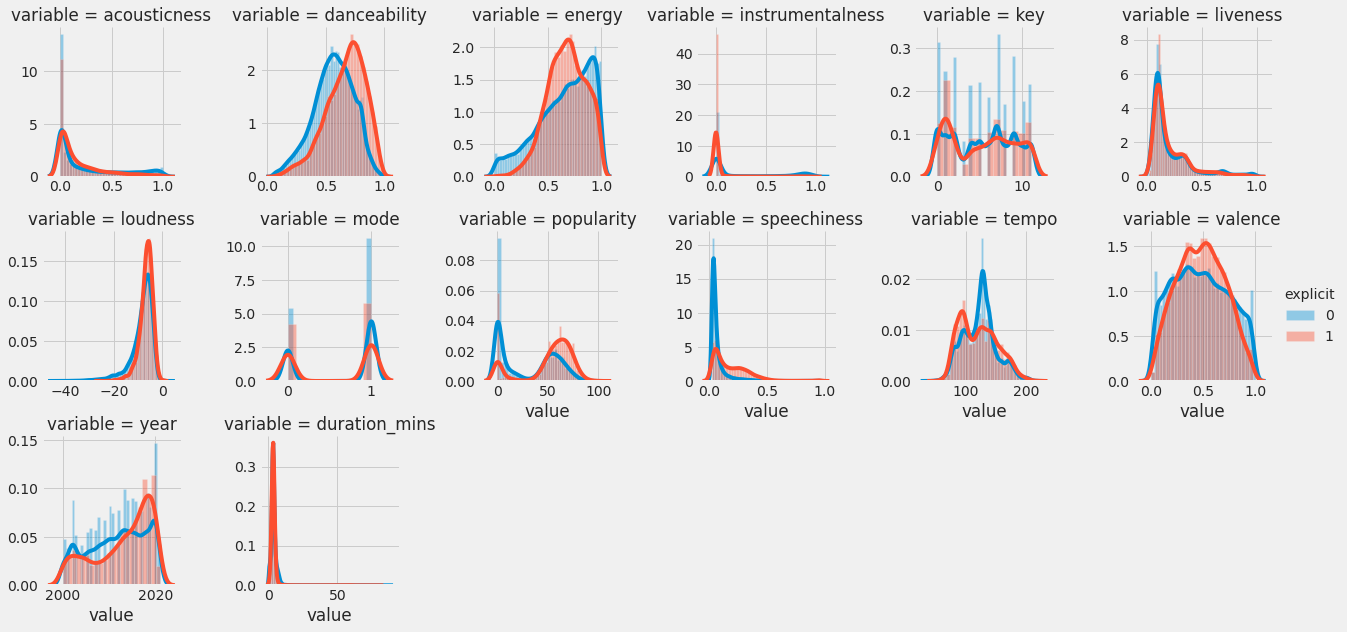

In [ ]:
# Distplot
plt.style.use('fivethirtyeight')
output = 'explicit'
 
cols = [ f for f in df.columns if df.dtypes[ f ] != "object"]
cols.remove( output )
 
f = pd.melt( df, id_vars=output, value_vars=cols)
g = sns.FacetGrid( f, hue=output, col="variable", col_wrap=6, sharex=False, sharey=False )
g = g.map( sns.distplot, "value", kde=True).add_legend()

Summary   
- Songs containing explicit contents are moderately danceable , energetic and have higher valence. 
- Explicit songs tend to have higher popularity scores, and these songs released more in recent years. 


### Features' range for popular songs

In [ ]:
df_popular = df[df['popularity'] > 75]
df_popular.shape

(1274, 15)

In [ ]:
des = df_popular.describe().round(2)
des

,acousticness,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year,duration_mins
count,1274.00,1274.00,1274.00,1274.00,1274.00,1274.00,1274.00,1274.00,1274.00,1274.00,1274.00,1274.00,1274.00,1274.00,1274.00
mean,0.25,0.67,0.63,0.41,0.01,5.33,0.17,-6.39,0.60,79.86,0.11,120.87,0.48,2017.20,3.41
std,0.26,0.14,0.18,0.49,0.09,3.58,0.12,2.52,0.49,3.90,0.10,29.34,0.22,4.24,0.74
min,0.00,0.21,0.02,0.00,0.00,0.00,0.03,-24.64,0.00,76.00,0.02,48.72,0.04,2000.00,1.08
25%,0.04,0.58,0.52,0.00,0.00,2.00,0.10,-7.67,0.00,77.00,0.04,97.01,0.31,2017.00,2.95
50%,0.15,0.68,0.64,0.00,0.00,5.00,0.12,-5.95,1.00,79.00,0.06,120.00,0.47,2019.00,3.38
75%,0.39,0.77,0.75,1.00,0.00,8.00,0.20,-4.75,1.00,82.00,0.13,140.06,0.64,2020.00,3.79
max,0.98,0.98,0.99,1.00,0.96,11.00,0.85,-1.19,1.00,100.00,0.78,220.10,0.97,2021.00,8.07


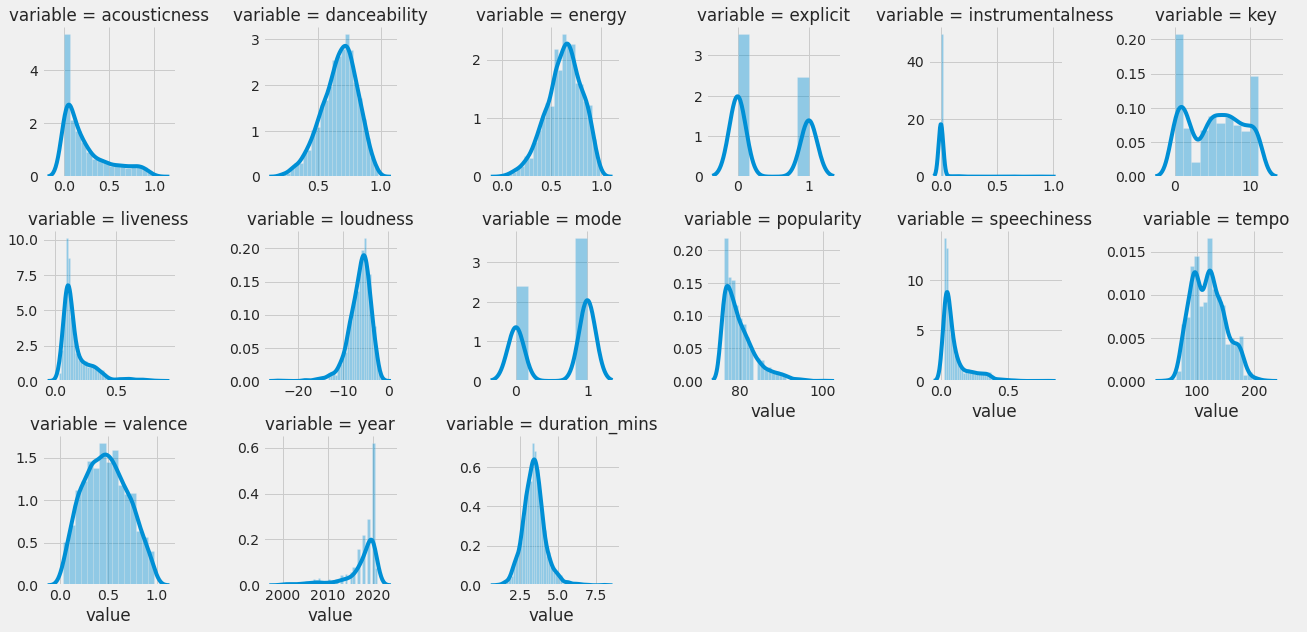

In [ ]:
# Visualizon
cols = [ f for f in df_popular.columns if df_popular.dtypes[ f ] != "object"]
 
f = pd.melt( df_popular, value_vars=cols)
g = sns.FacetGrid( f, col="variable", col_wrap=6, sharex=False, sharey=False )
g = g.map( sns.distplot, "value", kde=True).add_legend()

In [ ]:
# Calculate the confidence intervals for 95%
f_mean = des.iloc[1]
f_std = des.iloc[2]
interval_min = (f_mean.values - 1.96 * f_std / np.sqrt(1274))
interval_max = (f_mean.values + 1.96 * f_std / np.sqrt(1274))
min = pd.DataFrame(interval_min)
min.rename(columns={"std": "min"}, inplace=True)
max = pd.DataFrame(interval_max)
max.rename(columns={"std": "max"}, inplace=True)
pd.concat([min, max],axis=1)
mean = pd.DataFrame(f_mean)
pd.concat([min, mean, max],axis=1).round(2)

,min,mean,max
acousticness,0.24,0.25,0.26
danceability,0.66,0.67,0.68
energy,0.62,0.63,0.64
explicit,0.38,0.41,0.44
instrumentalness,0.01,0.01,0.01
key,5.13,5.33,5.53
liveness,0.16,0.17,0.18
loudness,-6.53,-6.39,-6.25
mode,0.57,0.60,0.63
popularity,79.65,79.86,80.07


### Artists recommendation

In [ ]:
# Define function which shows top three artists from specific feature
def recomend_artists(feature):
  recomendation = df_artists[df_artists[feature] > df_artists[feature].quantile(0.9)].sort_values(by='popularity', ascending=False)
  return recomendation.head(3)

In [ ]:
# Top 3 popluar artists:
df_artists.head(3)

,artists,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
242,"['24kGoldn', 'iann dior']",0.2210,0.700,140526.0,0.722,1.0,0.000000,7.0,0.2720,-3.558,0.0,96.0,0.0369,90.989,0.756,2020.0
1660,"['Bad Bunny', 'Jhay Cortez']",0.4010,0.731,205090.0,0.573,1.0,0.000052,4.0,0.1130,-10.059,0.0,95.0,0.0544,109.928,0.145,2020.0
1665,"['Bad Bunny', 'ROSALÃA']",0.0303,0.856,203201.0,0.618,0.0,0.000000,7.0,0.0866,-4.892,1.0,94.0,0.2860,81.993,0.391,2020.0


In [ ]:
# Top 3 Popluar artists with high danceability:
recomend_artists('danceability')

,artists,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
1665,"['Bad Bunny', 'ROSALÃA']",0.0303,0.856,203201.0,0.618,0.0,0.0,7.0,0.0866,-4.892,1.0,94.0,0.286,81.993,0.391,2020.0
2594,"['Cardi B', 'Megan Thee Stallion']",0.0194,0.935,187541.0,0.454,1.0,0.0,1.0,0.0824,-7.509,1.0,92.0,0.375,133.073,0.357,2020.0
11563,"['Pop Smoke', 'Lil Baby', 'DaBaby']",0.1140,0.823,190476.0,0.586,1.0,0.0,6.0,0.1930,-6.606,0.0,91.0,0.200,125.971,0.347,2020.0


In [ ]:
# Top 3 Popluar artists with high instrumentalness:
recomend_artists('instrumentalness')

,artists,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
4904,"['Erik Eriksson', 'White Noise Baby Sleep', 'W...",0.7910,0.000,90228.0,0.00342,0.0,1.000,8.0,0.1110,-28.460,1.0,84.0,0.0000,0.000,0.0000,2017.0
9012,"['Ludovico Einaudi', 'Daniel Hope', 'I Virtuos...",0.9340,0.447,315427.0,0.44900,0.0,0.961,2.0,0.0697,-10.634,1.0,76.0,0.0376,92.468,0.0360,2013.0
12395,['RÅ®DE'],0.0347,0.655,205766.0,0.48700,0.0,0.897,6.0,0.2710,-7.988,1.0,76.0,0.0330,139.914,0.0454,2017.0


# Hypothesis Testing

Text(0.5, 1.0, 'Density of Danceability\ncut by Explict')

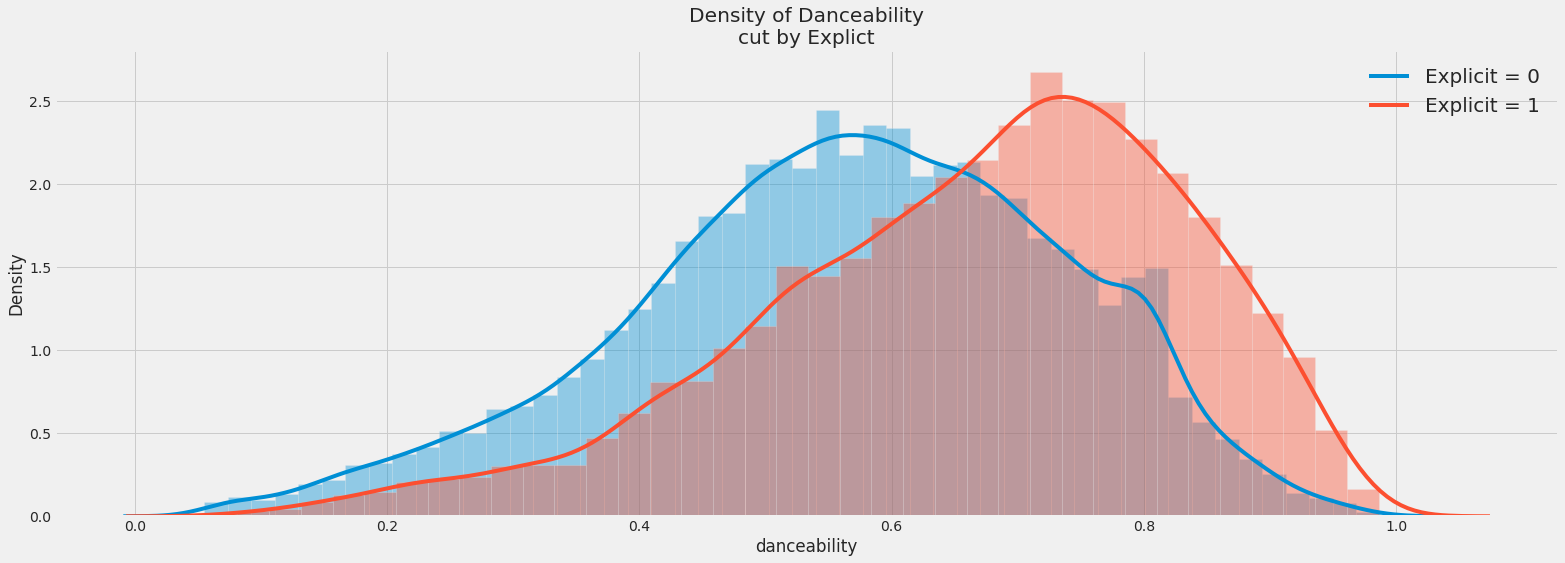

In [ ]:
# ANOVA test - danceability
plt.style.use('fivethirtyeight')
explicit_data0 = df["danceability"].loc[df["explicit"] == 0]
explicit_data1 = df["danceability"].loc[df["explicit"] == 1]

ax = sns.distplot(explicit_data0, hist=True, kde_kws=dict(linewidth=4))
ax = sns.distplot(explicit_data1, hist=True, kde_kws=dict(linewidth=4))
plt.legend(['Explicit = 0','Explicit = 1'],fontsize=20)
plt.title('Density of Danceability\ncut by Explict')

In [ ]:
# ANOVA - danceability
alpha = 0.05
explicit_stat, explicit_p = f_oneway(explicit_data0, explicit_data1)
print("Explicit statistics is %.3f, p value is %.3f" % (explicit_stat, explicit_p))
if explicit_p <= alpha:
  print("Reject H0. Different distribution (alpha = 0.05) ")
else:
  print("Fail to reject H0. Same distribution (alpha = 0.05)")

Explicit statistics is 1783.187, p value is 0.000
Reject H0. Different distribution (alpha = 0.05) 


Hypothesis test Analysis in danceability:
1. Test Setup:
- The Null Hypothesis (H0): The danceability of the tracks without explicit lyrics is the same as those songs with explicit songs.
- The Alternate Hypothesis (H1): The danceability of the tracks without explicit lyrics is different than those songs with explicit songs.
- The alpha-value will be set to 0.05.
2. Test Analysis:
- Claim is H0.
- Since p-value = 0 and it is less than the alpha-value = 0.05. We reject the null hypothesis.
- There is enough evidence to reject the claim that the danceability is the same regardless of the explicit contents.
- The danceability distribution of explicit songs is different than the distribution of songs without explicit contents.



Text(0.5, 1.0, 'Density of Valence\ncut by Explict')

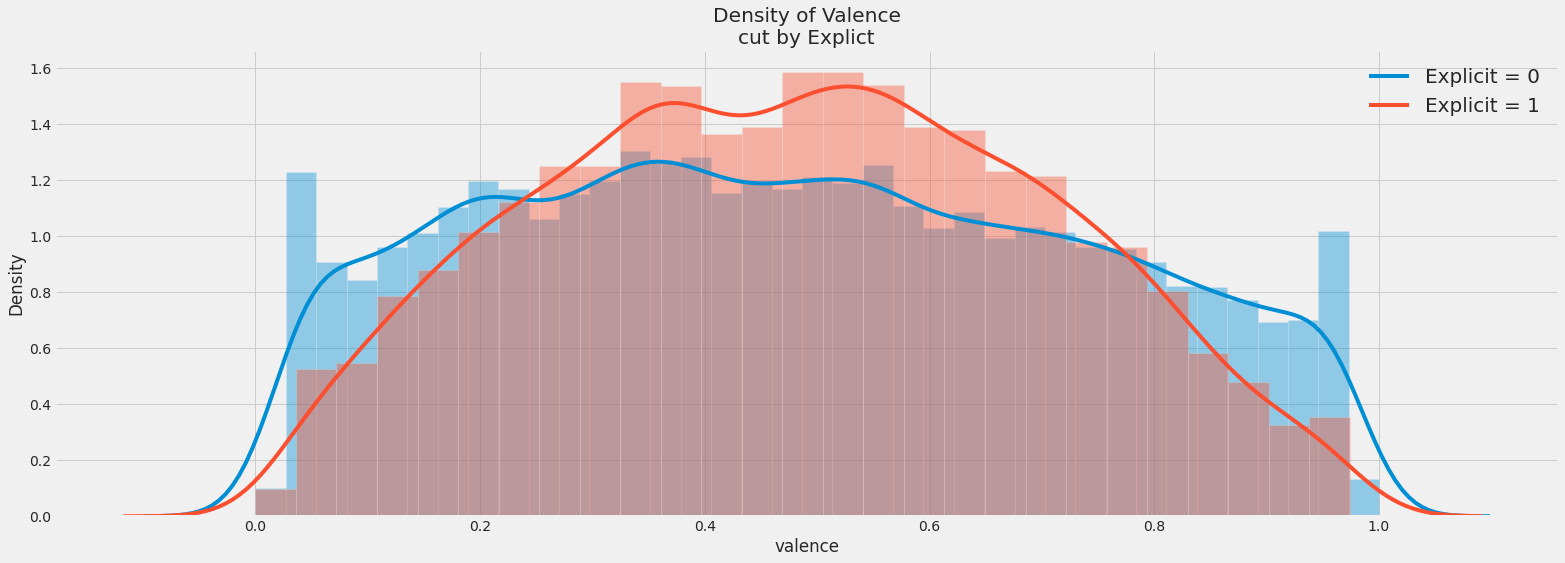

In [ ]:
# ANOVA test - valence
explicit_data0 = df["valence"].loc[df["explicit"] == 0]
explicit_data1 = df["valence"].loc[df["explicit"] == 1]

ax = sns.distplot(explicit_data0, hist=True, kde_kws=dict(linewidth=4))
ax = sns.distplot(explicit_data1, hist=True, kde_kws=dict(linewidth=4))
plt.legend(['Explicit = 0','Explicit = 1'],fontsize=20)
plt.title('Density of Valence\ncut by Explict')

In [ ]:
# ANOVA - valence
alpha = 0.05
explicit_stat, explicit_p = f_oneway(explicit_data0, explicit_data1)
print("Explicit statistics is %.3f, p value is %.3f" % (explicit_stat, explicit_p))
if explicit_p <= alpha:
  print("Reject H0. Different distribution (alpha = 0.05) ")
else:
  print("Fail to reject H0. Same distribution (alpha = 0.05)")

Explicit statistics is 0.341, p value is 0.559
Fail to reject H0. Same distribution (alpha = 0.05)


Hypothesis test Analysis in valence:
1. Test Setup:
- The Null Hypothesis (H0): The valence of the tracks without explicit lyrics is the same as those songs with explicit songs.
- The Alternate Hypothesis (H1): The valence of the tracks without explicit lyrics is different than those songs with explicit songs.
- The alpha-value will be set to 0.05.
2. Test Analysis:
- Claim is H0.
- Since p-value = 0.559 and it is much higher than the alpha-value = 0.05. We fail to reject the null hypothesis.
- The valence distribution of explicit songs is the same as songs without explicit contents .


In [ ]:
# Chi-square independent test
df.groupby("key")["explicit"].value_counts()

key  explicit
0    0           3673
     1            556
1    0           2889
     1            999
2    0           3262
     1            514
3    0            959
     1            133
4    0           2500
     1            398
5    0           2566
     1            398
6    0           2173
     1            465
7    0           3878
     1            596
8    0           1977
     1            482
9    0           3274
     1            471
10   0           2065
     1            449
11   0           2519
     1            569
Name: explicit, dtype: int64

In [ ]:
# Test for independent using Pearsons's Chi-squared Test
# H0: two variables are independent; H1: two variables are dependent
test_data   = [[3673, 556],
               [2889, 999],
               [3262, 514],
               [959, 133],
               [2500, 398],
               [2566, 398],
               [2173, 465],
               [3878, 596],
               [1977, 482],
               [3274, 471],
               [2065, 449],
               [2519, 569]]
alpha = 0.05
stat, p, dof, expected = chi2_contingency(test_data)

if p <= alpha:
  print("Reject H0. Explicit is dependent with key. (alpha = 0.05)")
else:
  print("Fail to reject H0. Explicit is independent with key. (alpha = 0.05)") 

Reject H0. Explicit is dependent with key. (alpha = 0.05)


Hypothesis test Analysis in key
1. Test Setup:
- The Null Hypothesis (H0): The key of songs is independent with explicit content .
- The Alternate Hypothesis (H1): The key of songs is dependent with explicit content.
- The alpha-value will be set to 0.05.
2. Test Analysis:
- Claim is H0.
- Since p-value is less than alpha value. We reject the null hypothesis.
- The key of songs is dependent with explicit content.


# Logistic Regression Model

In [ ]:
# Define function which find the best K (number of attributes) and the exact attributes as our training data
def run_logistic_regression_with_different_k(df, target_column):
    # Assign feature selection data 
    fs_y = df[target_column]
    fs_X = df.loc[:, df.columns != target_column]
    # Iterate with the number of X column 
    for i in range(fs_X.shape[1]):
      lr_model = LogisticRegression(max_iter=1000)
      rfe = RFE(lr_model, i+1)
      fit = rfe.fit(fs_X, fs_y)
      X_column = []
      # Iterate with fit.ranking to get the best attribute
      for j in range(len(fit.ranking_)):
        if fit.ranking_[j] == 1: # fit.ranking_ number equals to 1 indicates this attribute we want to select
          X_column.append(fs_X.columns[j])

      # Assign training and target data
      X = fs_X[X_column].values
      y = df[target_column]
      # Train and fit model
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
      lr_model.fit(X_train, y_train)
      y_predict = lr_model.predict(X_test)

      # Model evaluation metrics
      accuracy = accuracy_score(y_test, y_predict)
      mse = mean_squared_error(y_test, y_predict)
      cr_result = classification_report(y_test, y_predict)
      cv_scores = cross_val_score(lr_model, X, y, scoring='accuracy', cv=10)

      print("Select {} attributes as training data".format(i+1) )
      print("The training attributes includes:", X_column) 
      print("Model performance as below:")
      print("(1) Classification_report:")
      print(cr_result)
      print("(2) Accuracy:", accuracy) 
      print("(3) MSE:", mse)
      print("(4) Cross validation scores", cv_scores)
      print("(5) Cross validation mean scores", cv_scores.mean())
      print("----------------------------------------------------------")

In [ ]:
run_logistic_regression_with_different_k(df, "explicit")

Select 1 attributes as training data
The training attributes includes: ['speechiness']
Model performance as below:
(1) Classification_report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      7938
           1       0.59      0.14      0.23      1504

    accuracy                           0.85      9442
   macro avg       0.72      0.56      0.57      9442
weighted avg       0.82      0.85      0.81      9442

(2) Accuracy: 0.8475958483372167
(3) MSE: 0.15240415166278332
(4) Cross validation scores [0.83081811 0.85199894 0.85411702 0.85491131 0.84537993 0.84745763
 0.84772246 0.84798729 0.83951271 0.84639831]
(5) Cross validation mean scores 0.8466303700923969
----------------------------------------------------------
Select 2 attributes as training data
The training attributes includes: ['danceability', 'speechiness']
Model performance as below:
(1) Classification_report:
              precision    recall  f1-score   support

    

In [ ]:
X = df[['acousticness', 'danceability', 'energy', 'instrumentalness',
        'key', 'liveness', 'loudness', 'mode', 'popularity', 
        'speechiness', 'tempo', 'valence', 'year', 'duration_mins']].values
y = df["explicit"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
lr_explicit_model = LogisticRegression(max_iter=1000)
lr_explicit_model.fit(X_train, y_train)
y_predict = lr_explicit_model.predict(X_test)

# Model evaluation metrics
accuracy = accuracy_score(y_test, y_predict)
mse = mean_squared_error(y_test, y_predict)
cr_result = classification_report(y_test, y_predict)
cv_scores = cross_val_score(lr_explicit_model, X, y, scoring='accuracy', cv=10)

print("Model performance as below:")
print("(1) Classification_report:")
print(cr_result)
print("(2) Accuracy:", accuracy) 
print("(3) MSE:", mse)
print("(4) Cross validation scores", cv_scores)
print("(5) Cross validation mean scores", cv_scores.mean())

Model performance as below:
(1) Classification_report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      7938
           1       0.76      0.37      0.49      1504

    accuracy                           0.88      9442
   macro avg       0.83      0.67      0.71      9442
weighted avg       0.87      0.88      0.86      9442

(2) Accuracy: 0.8809574242745181
(3) MSE: 0.1190425757254819
(4) Cross validation scores [0.87609214 0.87053217 0.89939105 0.88271115 0.87450357 0.87658898
 0.88506356 0.87605932 0.86175847 0.88506356]
(5) Cross validation mean scores 0.87877639750856


# Prediction Model for popularity

# Predict for specific value (continuous variable)

In [ ]:
def run_regression_model(model, alg_name):
   # build the model on training data
   model.fit(X_train, y_train)
   # make predictions for test data
   y_pred = model.predict(X_test)
   mse = mean_squared_error(y_test, y_pred)  
   print("Model: ", alg_name)
   print("mse:", mse)
   print("Predictions", y_pred)

In [ ]:
def run_model(model, alg_name):
   # build the model on training data
   model.fit(X_train, y_train)
 
   # make predictions for test data
   y_pred = model.predict(X_test)
   # calculate the accuracy score
   accuracy =  accuracy_score(y_test, y_pred)
   cm = confusion_matrix(y_test, y_pred)
   scoresDT3 = cross_val_score(model, X_test, y_test, cv=6)
   Cr = classification_report(y_test, y_pred)
   
   print("Model: ", alg_name)
   print("Accuracy on Test Set for {} = {:.2f}\n".format(alg_name,accuracy))
   print(Cr)
   print("{}: CrossVal Accuracy Mean: {:.2f} and Standard Deviation: {:.2f} \n".format(alg_name,scoresDT3.mean(), scoresDT3.std()))

In [ ]:
# Prepare data for prediction
y = df['popularity']
X = df.drop(columns=['popularity'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [ ]:
# Transform features by scaling specific features to a given range
ctr = ColumnTransformer([('minmax', MinMaxScaler(), ['year', 'tempo', 'duration_mins']),
                        ('categorical', OneHotEncoder(), ['key'])],
                       remainder='passthrough')

In [ ]:
ctr.fit(X_train)
X_train_preprocessed = ctr.transform(X_train)
X_test_preprocessed = ctr.transform(X_test)

In [ ]:
# Linear Regression
model = LinearRegression()
run_regression_model(model, "Linear Regression")

Model:  Linear Regression
mse: 558.8565878549023
Predictions [37.33401535 34.995195   12.37524798 ... 40.72382427 15.40189785
  4.58028583]


In [ ]:
# Decision Tree Regression
model = DecisionTreeRegressor()
run_regression_model(model, "Decision Tree Regressor")

Model:  Decision Tree Regressor
mse: 786.0635988138106
Predictions [63. 44.  0. ... 48.  0.  0.]


In [ ]:
# XGB Regression
model = XGBRegressor()
run_regression_model(model, "XGB Regressor")

[05:06:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model:  XGB Regressor
mse: 445.6705715822151
Predictions [39.790062  41.78642   13.662247  ... 40.79386    1.0316939  2.3155956]


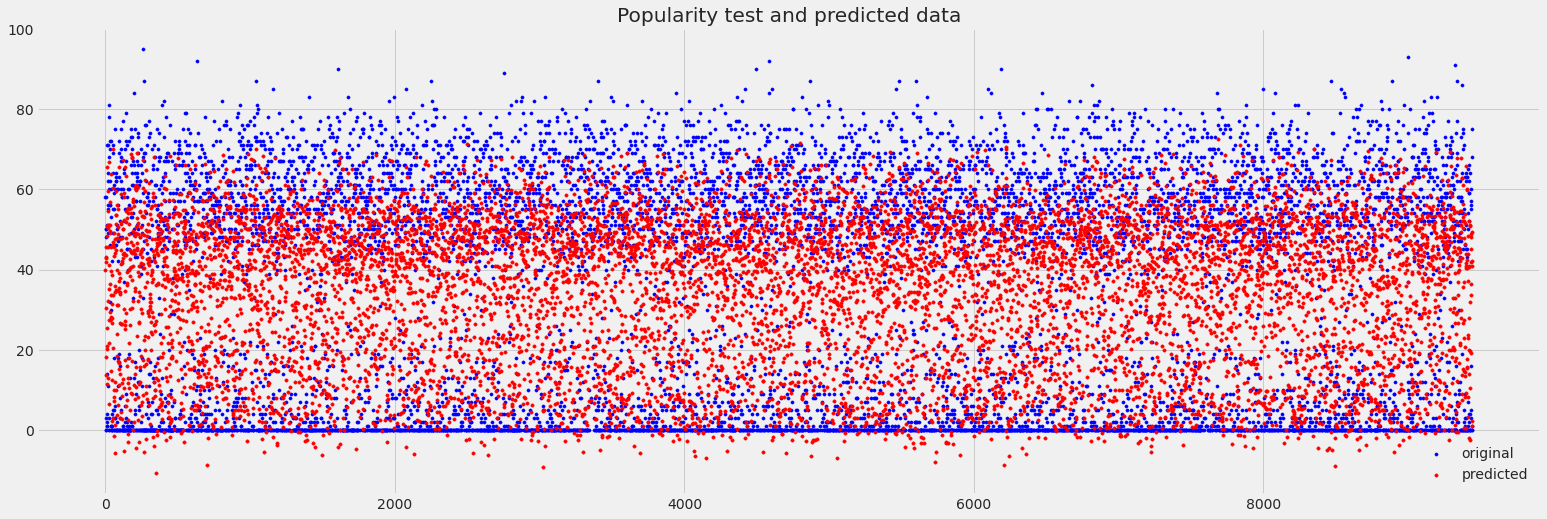

In [ ]:
# Predicted values visualization for XGB model
y_pred = model.predict(X_test)
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=10, color="blue", label="original")
plt.scatter(x_ax, y_pred, s=11, color="red", label="predicted")
plt.title("Popularity test and predicted data")
plt.legend()
plt.show()

# Categorize the popularity into 4 levels

In [ ]:
df_c = df.copy()

In [ ]:
df_c.loc[((df.popularity >= 0) & (df.popularity <= 25)), "popularity_level" ] = 1
df_c.loc[((df.popularity > 25) & (df.popularity <= 50)), "popularity_level" ] = 2
df_c.loc[((df.popularity > 50) & (df.popularity <= 75)), "popularity_level" ] = 3
df_c.loc[((df.popularity > 75) & (df.popularity <= 100)), "popularity_level" ] = 4

In [ ]:
df_c["popularity_level"] = df_c["popularity_level"].astype("int")

In [ ]:
df_c.drop(columns="popularity", inplace=True)

In [ ]:
df_c

,acousticness,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,year,duration_mins,popularity_level
0,0.84800,0.397,0.2420,0,0.000000,10,0.1060,-10.754,1,0.0663,171.747,0.1440,2008,4.067783,3
1,0.12200,0.751,0.4640,0,0.848000,7,0.2650,-10.527,1,0.1420,100.003,0.3680,2018,5.089900,1
2,0.36000,0.747,0.6190,0,0.000000,7,0.1320,-4.706,1,0.0360,92.124,0.6520,2008,3.888767,3
3,0.98400,0.183,0.0643,0,0.931000,7,0.0959,-16.565,1,0.0422,70.514,0.0551,2020,4.620450,1
4,0.98700,0.390,0.1290,0,0.904000,7,0.1190,-19.438,1,0.0369,63.911,0.3830,2020,3.840667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37804,0.05240,0.814,0.7850,0,0.001110,1,0.1110,-5.679,0,0.0396,120.009,0.9410,2018,4.250667,3
37805,0.00655,0.603,0.9640,0,0.000003,8,0.1430,-2.886,0,0.0487,135.028,0.7960,2018,3.436333,4
37806,0.02810,0.559,0.8730,0,0.000000,0,0.1850,-4.401,0,0.0543,150.055,0.7970,2019,3.493933,3
37807,0.13400,0.450,0.7820,0,0.000000,0,0.0632,-5.905,1,0.0306,87.980,0.4750,2015,3.068667,1


In [ ]:
y = df_c['popularity_level']
X = df_c.drop(columns=['popularity_level'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [ ]:
ctr = ColumnTransformer([('minmax', MinMaxScaler(), ['year', 'tempo', 'duration_mins']),
                        ('categorical', OneHotEncoder(), ['key'])],
                       remainder='passthrough')

In [ ]:
ctr .fit(X_train)
X_train_preprocessed = ctr .transform(X_train)
X_test_preprocessed = ctr .transform(X_test)

In [ ]:
model = RandomForestClassifier(n_estimators=10)
run_model(model, "Random Forest")

Model:  Random Forest
Accuracy on Test Set for Random Forest = 0.69

              precision    recall  f1-score   support

           1       0.78      0.84      0.81      4137
           2       0.49      0.39      0.43      1313
           3       0.65      0.69      0.67      3687
           4       0.42      0.07      0.12       305

    accuracy                           0.69      9442
   macro avg       0.58      0.50      0.51      9442
weighted avg       0.68      0.69      0.68      9442

Random Forest: CrossVal Accuracy Mean: 0.67 and Standard Deviation: 0.01 



In [ ]:
model = LogisticRegression(multi_class='multinomial')
run_model(model, "Logistic Regression")

Model:  Logistic Regression
Accuracy on Test Set for Logistic Regression = 0.52

              precision    recall  f1-score   support

           1       0.55      0.65      0.59      4137
           2       0.00      0.00      0.00      1313
           3       0.49      0.60      0.54      3687
           4       0.00      0.00      0.00       305

    accuracy                           0.52      9442
   macro avg       0.26      0.31      0.28      9442
weighted avg       0.43      0.52      0.47      9442

Logistic Regression: CrossVal Accuracy Mean: 0.53 and Standard Deviation: 0.01 



In [ ]:
model = KNeighborsClassifier()
run_model(model, "Nearest Neighbors Classifier")

Model:  Nearest Neighbors Classifier
Accuracy on Test Set for Nearest Neighbors Classifier = 0.60

              precision    recall  f1-score   support

           1       0.68      0.74      0.71      4137
           2       0.44      0.40      0.42      1313
           3       0.57      0.56      0.56      3687
           4       0.14      0.02      0.04       305

    accuracy                           0.60      9442
   macro avg       0.46      0.43      0.43      9442
weighted avg       0.58      0.60      0.59      9442

Nearest Neighbors Classifier: CrossVal Accuracy Mean: 0.58 and Standard Deviation: 0.00 



In [ ]:
# Random Forest Model as our prediction model
rf_model = RandomForestClassifier(n_estimators=10)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy =  accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
scoresDT3 = cross_val_score(rf_model, X_test, y_test, cv=6)
Cr = classification_report(y_test, y_pred)
   
print("Model: Random Forest model")
print("Accuracy on Test Set ={}".format(accuracy))
print(Cr)
print("CrossVal Accuracy Mean: {:.2f} and Standard Deviation: {:.2f} \n".format(scoresDT3.mean(), scoresDT3.std()))

Model: Random Forest model
Accuracy on Test Set =0.6952976064393137
              precision    recall  f1-score   support

           1       0.78      0.84      0.81      4137
           2       0.49      0.40      0.44      1313
           3       0.66      0.69      0.67      3687
           4       0.43      0.10      0.17       305

    accuracy                           0.70      9442
   macro avg       0.59      0.51      0.52      9442
weighted avg       0.68      0.70      0.68      9442

CrossVal Accuracy Mean: 0.68 and Standard Deviation: 0.01 



In [ ]:
# Generate 1000 random sample
random_input = pd.DataFrame(columns = df_c.columns)
random.seed(42)
for i in range(1000):
  x = [random.uniform(0, 1) for i in range(3)]
  x.append(random.randint(0,1))
  x.append(random.uniform(0,1))
  x.append(random.randint(0,11))
  x.append(random.randint(0,1))
  x.append(random.randint(-9,-5))
  x.append(random.randint(0,1))
  x.append(random.uniform(0,1))
  x.append(random.uniform(100,150))
  x.append(random.uniform(0,1))
  x.append(random.randint(2000,2021))
  x.append(random.uniform(0,88))
  x.append(random.randint(0,4))
  random_input.loc[i] = x

In [ ]:
sample_data = random_input.drop(columns=["popularity_level"])

In [ ]:
sample_data

,acousticness,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,year,duration_mins
0,0.639427,0.025011,0.275029,0.0,0.139538,1.0,0.0,-5.0,1.0,0.031783,104.684762,0.232661,2019.0,2.335165
1,0.716020,0.701325,0.419520,1.0,0.589266,0.0,0.0,-6.0,1.0,0.277871,110.765688,0.763494,2003.0,8.161634
2,0.358979,0.343956,0.264521,0.0,0.729732,8.0,0.0,-6.0,0.0,0.552041,141.470233,0.618520,2011.0,50.806989
3,0.045824,0.227898,0.289388,0.0,0.855318,1.0,1.0,-7.0,1.0,0.635684,118.241609,0.370181,2006.0,58.975415
4,0.609131,0.171139,0.729127,0.0,0.462260,4.0,0.0,-7.0,0.0,0.229048,101.605012,0.315453,2008.0,5.824597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.789543,0.897056,0.824191,1.0,0.107538,9.0,1.0,-5.0,0.0,0.831802,114.222243,0.064943,2019.0,75.010799
996,0.643464,0.699943,0.096120,0.0,0.689032,0.0,1.0,-7.0,0.0,0.694909,140.513539,0.358752,2016.0,26.963091
997,0.417970,0.930497,0.794258,1.0,0.666255,3.0,0.0,-6.0,0.0,0.703235,101.839883,0.058748,2003.0,12.995837
998,0.126110,0.722770,0.282475,1.0,0.687726,9.0,0.0,-6.0,1.0,0.409881,146.493664,0.668269,2021.0,48.586581


In [ ]:
y_sample_pred = rf_model.predict(sample_data)

In [ ]:
sample_data = sample_data.join(pd.DataFrame(y_sample_pred, columns= {"popularity_level"}))

In [ ]:
sample_data

,acousticness,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,year,duration_mins,popularity_level
0,0.639427,0.025011,0.275029,0.0,0.139538,1.0,0.0,-5.0,1.0,0.031783,104.684762,0.232661,2019.0,2.335165,1
1,0.716020,0.701325,0.419520,1.0,0.589266,0.0,0.0,-6.0,1.0,0.277871,110.765688,0.763494,2003.0,8.161634,3
2,0.358979,0.343956,0.264521,0.0,0.729732,8.0,0.0,-6.0,0.0,0.552041,141.470233,0.618520,2011.0,50.806989,1
3,0.045824,0.227898,0.289388,0.0,0.855318,1.0,1.0,-7.0,1.0,0.635684,118.241609,0.370181,2006.0,58.975415,1
4,0.609131,0.171139,0.729127,0.0,0.462260,4.0,0.0,-7.0,0.0,0.229048,101.605012,0.315453,2008.0,5.824597,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.789543,0.897056,0.824191,1.0,0.107538,9.0,1.0,-5.0,0.0,0.831802,114.222243,0.064943,2019.0,75.010799,1
996,0.643464,0.699943,0.096120,0.0,0.689032,0.0,1.0,-7.0,0.0,0.694909,140.513539,0.358752,2016.0,26.963091,1
997,0.417970,0.930497,0.794258,1.0,0.666255,3.0,0.0,-6.0,0.0,0.703235,101.839883,0.058748,2003.0,12.995837,1
998,0.126110,0.722770,0.282475,1.0,0.687726,9.0,0.0,-6.0,1.0,0.409881,146.493664,0.668269,2021.0,48.586581,1


In [ ]:
sample_data.popularity_level.value_counts()

1    878
2     82
3     40
Name: popularity_level, dtype: int64

In [ ]:
sample_data.popularity_level

0      1
1      3
2      1
3      1
4      1
      ..
995    1
996    1
997    1
998    1
999    1
Name: popularity_level, Length: 1000, dtype: int64

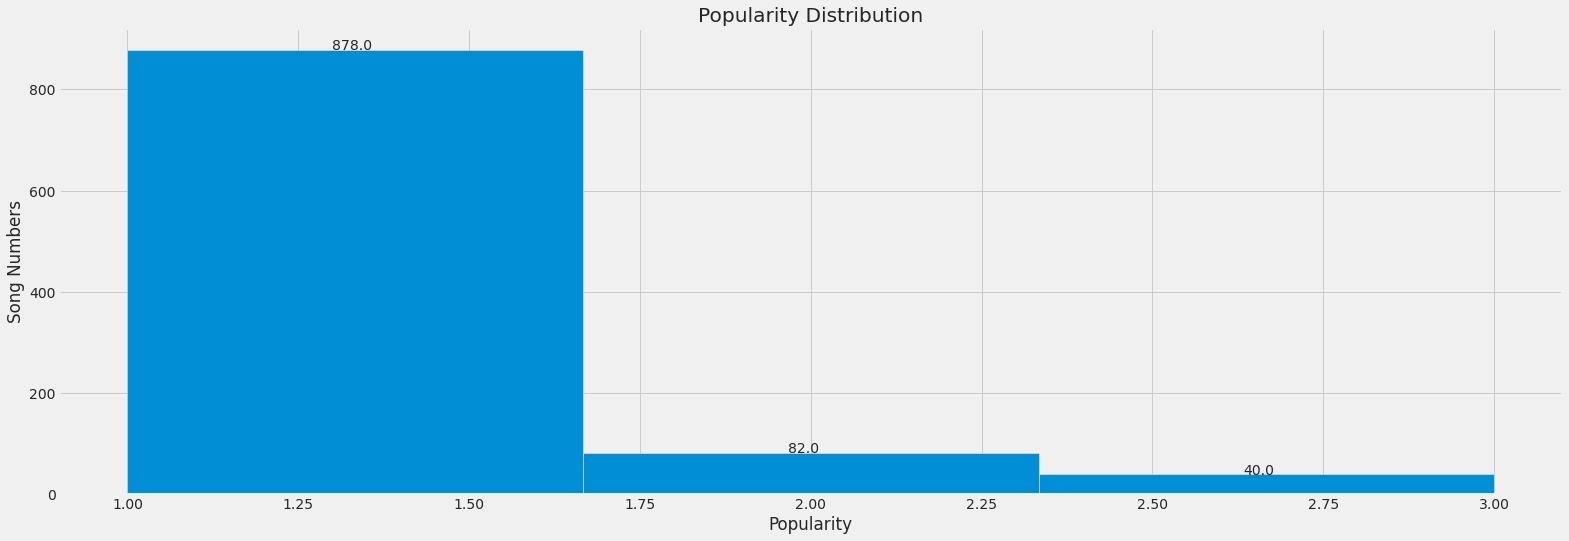

In [ ]:
# Visualize histogram - predicted popularity
ax = plt.hist(sample_data['popularity_level'], bins=3)
for i in range(3):
    plt.text(ax[1][i] +0.3, ax[0][i],str(ax[0][i]))
plt.xlabel('Popularity')
plt.ylabel('Song Numbers')
plt.title('Popularity Distribution');

##